# World Data League 2023

## 🎯 Challenge
Avencas Marine Protected Area: Predict the future of the local ecosystem and its species


<img src="wdl_2023.png" alt="MoMoneyMoModels_Badge_whitebackground.png" style="width:35%">

## Team: Mo Money, Mo Models
## 👥 Authors
* David Raposo
* Duarte Pereira
* Martim Chaves
* Paulo Sousa


## 💻 Development

### Introduction

#### The place

Avencas, near Lisbon, Portugal, was classified as a Biophysical Interest Zone (ZIBA) in 1998 due to its **high intertidal biodiversity**.

This classification **sparked controversy and conflict with locals**, leading to **non-compliance** with regulations. In 2016, after concerted efforts from local authorities, Avencas was reclassified as a Marine Protected Area (MPA). Marine Protected Areas (MPAs) constitute coastal management tools that aim to mitigate threats to the functioning of the areas and can be planned according to diﬀerent speciﬁc objectives.

Along with the reclassification, **public participation sessions and environmental awareness** activities were carried out, **improving regulation compliance**, particularly within the **fishing community**.

Certain activities, including aquaculture, water motor sports, fishing, and collection of animals, are prohibited unless authorized for scientific studies. (From Ferreira et al. 2017)

#### A Success Story

"[...] user management actions have been created including visitors’ pathways through the rocky platforms and information spots displaying signs with area specific rules at the entrance to the beach. Positive results point to the success of this approach, as visitors either agreed or respected the various management actions implemented. A survey showed that 84% of visitors look favorable upon the information spots and 76% agree with the location of the access pathways. " (Challenge Brief)

#### A Problem Arises...

But... "The local usages are now under control, [...] allowing for a decrease in the anthropogenic stress of this small MPA, so in theory the intertidal ecosystem should be recovering at a faster rate than what is being recorded by our teams of biologists." In other words: locals are now not adding stress to the MPA. But, it's still not recovering as fast as we expected. So, some other factors are probably at play here, likely related to the global changes to the climate that we are witnessing.

#### The Solution

Knowing this, a great tool to further improve the biodiversity, and assure the health and sustainability of the Avencas MPA, would be an **interactive app** that could visually represent the species coverage/count in the MPA, and informs the locals and the general populace of how important sessile species are for the Avencas MPA, and for marine life overall.

This could be in the form of an **interactive, sea-side screen**, and an **online web app**.

The **goal** of this app would be to, **beyond the specific Avencas MPA**, captivate people, locals and non-locals, to how important marine life can be, and to incentivize them to become **champions of environmentally friendly causes**, so that they may pressure policy makers, and contribute towards meaningful, large scale, change.

Sessile species highly contribute towards MPAs, in several ways. Here's some that could be emphasized:

* Biodiversity: Our ocean is amazing - it's a home for all sorts of sessile organims like algae, coral, and even sea slugs! All of these different being create complex neighboorhoods that host a wild variety of life. Some call corals "rainforests of the sea", as they're teeming with fascinating biodiversity!

* Food Source: Each being plays a part in these complex neighboorhouds down under the sea. Some are treats for other larger beings, like algae, mussels, and barnacles, while other act as an amazing clean-up crew, like the amazing fungi. Each being is important, as each is a key element to the assurance of the marina areas, keeping the ocean clean and healthy!

* Carbon Sequestration: Also, another major role that algae and coral play is when it come to sucking up carbon dioxide and giving oxygen in return, aiding us in fighting climate change. Besides being pretty, they're also working hard to keep our planet cooool.

("Marine Biology: An Ecological Approach" by Nybakken and Bertness, "Dynamics of Marine Ecosystems: Biological-Physical Interactions in the Oceans" by Mann and Lazier)

But first... let's look at the data that we have at hand!

### EDA

Examining the structure, contents, and basic statistics of the dataset. 

#### Imports and Setup

In [4]:
# Relevant Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np

In [5]:
# set Seaborn style and context
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context('notebook')

#### Initial Feel

In [6]:
data_path = os.path.join("data", "raw", "files_WDL", "cascais_data", "AMPA_Data_Sample.xlsx")

with pd.ExcelFile(data_path) as xls:
    sheet_names = xls.sheet_names          

print(sheet_names) 

['Sessil (% Coverage)', ' Mobil (nº individuals)', 'Invasive_conservat species list']


Our main dataset has 3 sheets.

Opening each sheet, visually, we can understand that:
1. 'Sessil (% Coverage)' focuses on sessile species, i.e. species that fixate on a substracte. It contains measures of percentage of coverage for each specie being analysed for a random "quadrat" in one of five sectors of the MPA. These measures seem to be taken sporadically, around a couple of times per month, over the span of many years, from 2011 to 2020.
2. ' Mobil (nº individuals)' is similar to the previous sheet, but contains only mobile species.
3. 'Invasive_conservat species list' dictates which species are invasive, and which are under risk of extinction.

#### Reading the Data

In [7]:
sessil_df = pd.read_excel(data_path, sheet_name=sheet_names[0])
mobil_df = pd.read_excel(data_path, sheet_name=sheet_names[1])
invsve_df = pd.read_excel(data_path, sheet_name=sheet_names[2])

##### Removing extra unecessary columns

Visually, it has been understood that there are some columns that are not relevant to us, and that can be dropped.
They are information about who took the sample, and two extra columns that contain no information. So, let's get rid of them! :)

In [8]:
columns_to_drop_sessil = ['Sampler', 'Coluna1', 'Coluna2']
columns_to_drop_mobile = ['Sampler', 'Column1', 'Column2', 'Column3']

sessil_df = sessil_df.drop(columns_to_drop_sessil, axis=1)
mobil_df = mobil_df.drop(columns_to_drop_mobile, axis=1)

#### Join Sessil and Mobil Data

The goal of this section is to join the Sessil and Mobil dataframes.

The key components to do this are Date, Hour, Zone, and, within the zone, Supra/Middle (closer or further away from the coast).

These components should allow us to join these dataframes in a way that makes sense, i.e., for the same date and hour, and the same general area, we'll have an idea of which species are abound. :)

Ideally, all of the other columns that have meta information such as Tide, and Weather Condition would be included, but, as we'll find out in a second, that's not ideal...

So, to start off, we have to get an idea of missing values for these particular columns.

##### Analysing Missing Values of Relevant Columns

In [9]:
rel_column_names = ['Date', 'Hour', 'Zone', 'Supratidal/Middle Intertidal']

for col in rel_column_names:
    missing_vals_sessil = sessil_df[col].isnull().sum()
    missing_vals_mobile = mobil_df[col].isnull().sum()

    print(f"Missing values for column {col} for sessil_df: {missing_vals_sessil}")
    print(f"Missing values for column {col} for mobile_df: {missing_vals_mobile}")

Missing values for column Date for sessil_df: 1
Missing values for column Date for mobile_df: 93
Missing values for column Hour for sessil_df: 1
Missing values for column Hour for mobile_df: 93
Missing values for column Zone for sessil_df: 1
Missing values for column Zone for mobile_df: 93
Missing values for column Supratidal/Middle Intertidal for sessil_df: 1
Missing values for column Supratidal/Middle Intertidal for mobile_df: 93


Interesting, let's check if whenever there's a missing value for one of our relevant columns, if that's also the case for the other relevant columns... We want a heatmap that shows pairwise overlaps in missingness. Essentially, for any two given columns, we want to know what percent of the rows are missing in both.

In [10]:
def plot_missing_overlap(df, rel_column_names, annot=True):
    # Initialize a dataframe of zeros with the same column and index as rel_column_names
    overlaps = pd.DataFrame(0, index=rel_column_names, columns=rel_column_names, dtype=float)
        
    # For each pair of columns, calculate the overlap in missingness and store it in 'overlaps'
    for col1 in rel_column_names:
        for col2 in rel_column_names:
            # Calculate overlap between two columns
            overlap = df[col1].isnull() & df[col2].isnull()
            overlaps.loc[col1, col2] = overlap.sum() / df[col2].isnull().sum()
    
    # Create a mask to only show the lower triangle
    mask = np.triu(np.ones_like(overlaps, dtype=bool))
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(overlaps, mask=mask, annot=annot, fmt=".2%", cmap='Blues', cbar=True, square=True)
    plt.title('Overlap of Missing Values')
    plt.show()

sessil_df


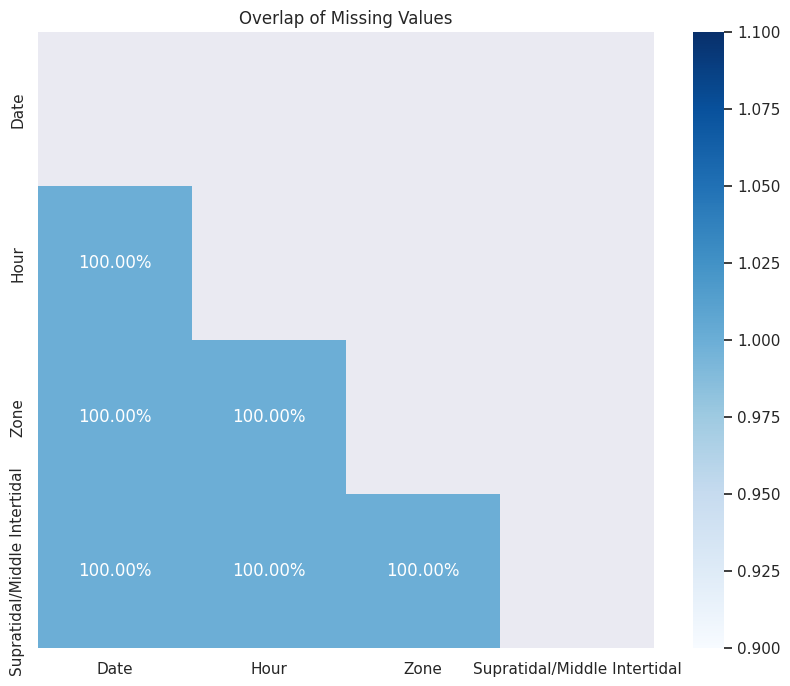

In [11]:
# Plot for both dataframes
print("sessil_df")
plot_missing_overlap(sessil_df, rel_column_names)

mobil_df


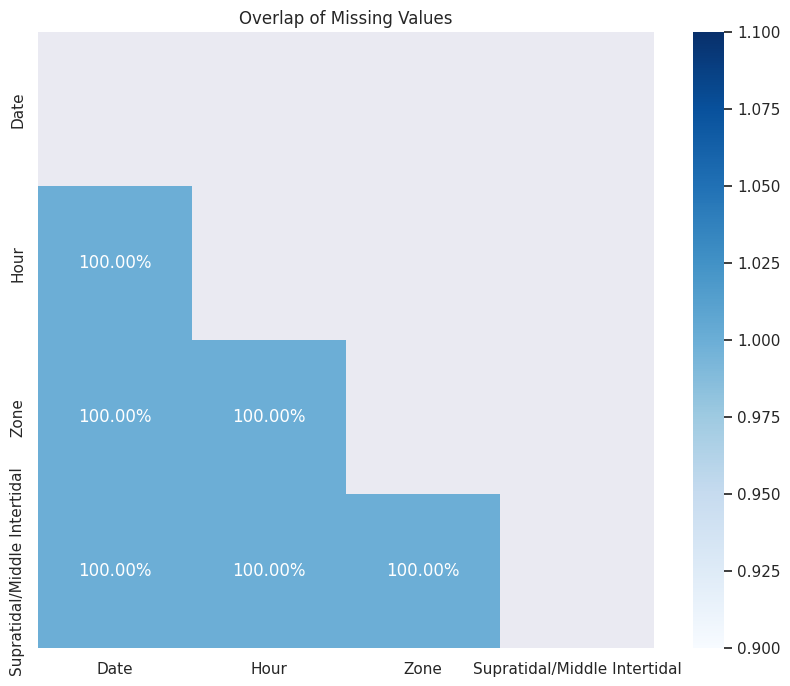

In [12]:
print("mobil_df")
plot_missing_overlap(mobil_df, rel_column_names)

We can conclude that when there's a missing Date, there's a missing Hour, and so on... Let's drop the rows where there are missing values from our relevant columns. (We also checked that we were't losing a lot of interesting info by doing this, charts for that in the Visualizations tab)

In [13]:
# Drop NAs
sessil_df = sessil_df.dropna(subset=rel_column_names)
mobil_df = mobil_df.dropna(subset=rel_column_names)

##### Formating 'Date' and 'Hour'

We'll also add a 'DateTime' column for sorting the rows later...

###### Formating Sessil DF code

In [14]:
def fix_sessil_time_format(time_str):
    """
    This has to be done because the time was probably inputed by hand,
    so it varies a bit. This is to take into account those variations.
    """
    try:
        # Attempt to convert the time string into the usual format
        time_obj = pd.to_datetime(time_str, format="%H:%M:%S").time()
    except ValueError:
        try:
            # If a ValueError is raised, try to convert from "%H:%M" format
            time_obj = pd.to_datetime(time_str, format="%H:%M").time()
        except ValueError:
            # If a ValueError is still raised, try to convert from "%H.%M" format
            time_obj = pd.to_datetime(time_str, format="%H.%M").time()
    # Return the time object in string format with "%H:%M:%S"
    return time_obj.strftime("%H:%M:%S")

In [15]:
def format_date_hour_sessil(sessil_meta_df):
    # Stringify Date and Hour
    sessil_meta_df['Date'] = sessil_meta_df['Date'].astype(str)
    sessil_meta_df['Hour'] = sessil_meta_df['Hour'].astype(str)

    # Change formats
    sessil_meta_df['Date'] = pd.to_datetime(sessil_meta_df['Date'], format="%Y-%m-%d")
    sessil_meta_df['Hour'] = sessil_meta_df['Hour'].apply(fix_sessil_time_format)

    # Add DateTime Column
    sessil_meta_df['DateTime'] = pd.to_datetime(\
        sessil_meta_df['Date'].astype(str) + ' ' + sessil_meta_df['Hour'].astype(str))
    
    return sessil_meta_df

###### .

In [16]:
sessil_df = format_date_hour_sessil(sessil_df)

###### Formating Mobil DF code

In [17]:
def fix_mobil_date_format_row(date_str, prev_date):
    try:
        # Attempt to convert the date string into the usual format
        pd.to_datetime(date_str, format="%Y-%m-%d", errors='raise')
        return date_str
    except ValueError:
        try:
            # If a ValueError is raised, try to convert from "%d-%m-%Y" format to "%Y-%m-%d" format
            return pd.to_datetime(date_str, format="%d-%m-%Y").strftime("%Y-%m-%d")
        except ValueError:
            # If another ValueError is raised, return the previous date
            return prev_date

def fix_mobil_date_format(mobile_meta_df):
    prev_date = None
    for i in range(len(mobile_meta_df)):
        current_date = fix_mobil_date_format_row(mobile_meta_df.loc[i, 'Date'], prev_date)
        mobile_meta_df.loc[i, 'Date'] = current_date
        prev_date = current_date

    # Then, convert the 'Date' column into datetime format
    mobile_meta_df['Date'] = pd.to_datetime(mobile_meta_df['Date'], format="%Y-%m-%d")

    return mobile_meta_df

In [18]:
def fix_time_format_mobil(time_str):
    try:
        # First check if time_str is a decimal (like '0.5104166666666666')
        # If it is, convert to time directly
        time_fraction = float(time_str)
        time_obj = pd.to_datetime((time_fraction * 24 * 60 * 60), unit='s').time()
    except ValueError:
        try:
            # Attempt to convert the time string into the usual format
            time_obj = pd.to_datetime(time_str, format="%H:%M:%S").time()
        except ValueError:
            try:
                # If a ValueError is raised, try to convert from "%H:%M" format
                time_obj = pd.to_datetime(time_str, format="%H:%M").time()
            except ValueError:
                # If a ValueError is still raised, try to convert from "%H.%M" format
                time_obj = pd.to_datetime(time_str, format="%H.%M").time()
    # Return the time object in string format with "%H:%M:%S"
    return time_obj.strftime("%H:%M:%S")

In [19]:
def format_date_hour_mobil(mobile_meta_df):
    # Stringify Date and Hour
    mobile_meta_df['Date'] = mobile_meta_df['Date'].astype(str)
    mobile_meta_df['Hour'] = mobile_meta_df['Hour'].astype(str)

    # Fix Date and Hour format
    mobile_meta_df = fix_mobil_date_format(mobile_meta_df)
    mobile_meta_df['Hour'] = mobile_meta_df['Hour'].apply(fix_time_format_mobil)

    # Add DateTime column
    mobile_meta_df['DateTime'] = pd.to_datetime(\
        mobile_meta_df['Date'].astype(str) + ' ' + mobile_meta_df['Hour'].astype(str))
    
    return mobile_meta_df

###### .

In [20]:
mobil_df = format_date_hour_mobil(mobil_df)

##### Merging Sessil and Mobil

We'll be doing a left join of the Sessil df with the Mobil df. We're sort of giving priority to the Sessil data as it was the one with, so far, highest data quality (in terms of missing and invalid data).

In [21]:
def study_merging(sessil_df, mobil_df, columns_to_compare):
    merged_df = pd.merge(sessil_df[columns_to_compare],
                         mobil_df[columns_to_compare],
                         on=columns_to_compare, 
                         how='left', indicator=True)
    
    missing_rows = merged_df[merged_df['_merge'] == 'left_only']

    return len(merged_df), len(missing_rows)

In [22]:
['DateTime', 'Tide', 'Weather Condition',
'Water temperature (ºC)', 'Zone',
'Supratidal/Middle Intertidal', 'Substrate']

['DateTime',
 'Tide',
 'Weather Condition',
 'Water temperature (ºC)',
 'Zone',
 'Supratidal/Middle Intertidal',
 'Substrate']

In [23]:
columns_to_compare = ['DateTime', 'Zone', 'Supratidal/Middle Intertidal']

merge_len, missing_len = study_merging(sessil_df, mobil_df, columns_to_compare)
print(f"Merged length: {merge_len}; Missing rows length: {missing_len}")

Merged length: 3516; Missing rows length: 52


Merged length represents the number of rows obtained after the merge. Note that this can be larger than the length of sessil df when there are "duplicates" in mobil df ("duplicates" with quotes because we're talking about duplicates of the specific columns that we're using, other columns may not necessarily be duplicates). Ideally, we want to keep this number as close as possible to the length of sessil df, which is 2010. This means that we're merging on unique combinations of values.

Then, missing rows are rows in the mobil df that are left behind, since we're doing a left join. Ideally, we want to keep this number as low as possible, to not lose any information from mobil df.

We tried several configurations on how to do this join. Unfortunately, there was no perfect way.

So, we opted for doing a join on the ['DateTime', 'Zone', 'Supratidal/Middle Intertidal'] columns.
This way, we're guaranteeing that, for each row, the data present there sort of belongs to the same key comnponents, which is day of the year, hour of the day, and location (combination of Zone and Tidal location).

Before doing the join, we'll drop the mobil df "duplicates" to have one sample per each Date, Hour, Zone, Tide location (keeping the first one). Also, we're only interested in the values of the species, so we'll drop all of the other columns as well, containing meta information. Since they are mobile species, we considered that it was more important to keep the information about substrate and so on of the sessil df.

###### List of different groups of Columns 

In [24]:
mobil_meta_columns = ['Date', 'Hour', 'Tide', 'Weather Condition',
                      'Water temperature (ºC)', 'Zone',
                      'Supratidal/Middle Intertidal',
                      'Substrate', 'DateTime']

In [25]:
mobil_species_columns = [col for col in mobil_df.columns if col not in mobil_meta_columns]

In [26]:
sessil_meta_columns = ['Date', 'Hour', 'Tide', 'Weather Condition',
                       'Water temperature (ºC)', 'Zone',
                       'Supratidal/Middle Intertidal', 'Substrate',
                       'observações', 'DateTime']

In [27]:
sessil_species_columns = [col for col in sessil_df.columns if col not in sessil_meta_columns]

###### List of Mobil df columns to drop

In [28]:
# All meta info except ['DateTime', 'Zone', 'Supratidal/Middle Intertidal'] (columns_to_compare)
mobil_columns_2drop = ['Date', 'Hour', 'Tide', 'Weather Condition',
                      'Water temperature (ºC)', 'Substrate']

# drop the unwanted columns from mobil_df
mobil_df_reduced = mobil_df.drop(columns=mobil_columns_2drop)

# Drop duplicates based on columns_to_compare in mobil_df, keeping the first occurrence
mobil_df_reduced = mobil_df_reduced.drop_duplicates(subset=columns_to_compare, keep='first')

###### Left join data!

In [29]:
# merge the dataframes
df = pd.merge(sessil_df, mobil_df_reduced,
              on=columns_to_compare, how='left')

In [30]:
df

,Date,Hour,Tide,Weather Condition,Water temperature (ºC),Zone,Supratidal/Middle Intertidal,Substrate,Chthamalus sp.,Balanus perforatus,...,Nudibranquio N.I.,Callionymus lira (peixe-pau lira),Oncidiella celtica,Doriopsilla areolata (nudibrânquio),Scorpaena sp. (Rascasso),Lipophrys pholis (ad.),Diplodus cervinus,Gobiusculus flavescens,TOTAL,Abundance (ind/m2)
0,2011-11-28,12:20:00,0.6,Clear sky,16,D,Supra,Rock,7,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.05
1,2011-11-28,12:35:00,0.6,Clear sky,16,D,Supra,Rock,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,2011-11-28,10:10:00,0.6,Clear sky,16,D,Medium,Puddle,0,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.20
3,2011-11-28,10:25:00,0.6,Clear sky,16,D,Medium,Rock,8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.10
4,2011-11-28,10:40:00,0.6,Clear sky,16,D,Medium,Rock,25,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,2020-11-16,08:00:00,0.4,Sunny,18,F,Medium,Rock/Sand,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.25
2006,2020-11-16,08:00:00,0.4,Sunny,18,F,Medium,Rock/Sand,17,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.25
2007,2020-11-16,08:00:00,0.4,Sunny,18,F,Medium,Rock,10,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.25
2008,2020-11-16,08:00:00,0.4,Sunny,18,F,Supra,Rock,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


Hurray!! Now we have both the Sessil and Mobil data combined!

#### Analysis of Data Types

Let's analyse the meta information, such as the Date and Hour of sample collection, the substrate, and so on!

In [31]:
def initial_data_profiling(data: pd.DataFrame):
    # Get the data types of each column
    data_types = data.dtypes

    # Get the summary statistics of the DataFrame
    summary_stats = data.describe()

    # Get the number of missing values in each column
    missing_values = data.isnull().sum()

    # Get the unique values in each column
    unique_values = data.nunique()

    # Display the data profiling information
    print("Data Types:")
    print(data_types)
    print("\nSummary Statistics:")
    print(summary_stats)
    print("\nMissing Values:")
    print(missing_values)
    print("\nUnique Values:")
    print(unique_values)

In [32]:
print("Analysis of samples' meta info")
initial_data_profiling(df[sessil_meta_columns])

Analysis of samples' meta info
Data Types:
Date                            datetime64[ns]
Hour                                    object
Tide                                   float64
Weather Condition                       object
Water temperature (ºC)                  object
Zone                                    object
Supratidal/Middle Intertidal            object
Substrate                               object
observações                             object
DateTime                        datetime64[ns]
dtype: object

Summary Statistics:
              Tide
count  2010.000000
mean      0.729035
std       0.184047
min       0.300000
25%       0.600000
50%       0.700000
75%       0.900000
max       2.400000

Missing Values:
Date                               0
Hour                               0
Tide                               0
Weather Condition                  0
Water temperature (ºC)             8
Zone                               0
Supratidal/Middle Intertidal       0
Subst

In [33]:
df[sessil_species_columns].dtypes

Chthamalus sp.                               object
Balanus perforatus                           object
Patella sp.                                  object
Siphonaria algesirae                        float64
Gibbula sp.                                 float64
                                             ...   
Alga verde/azul - lavanda                   float64
Sphacelaria rigidula (pompons castanhos)    float64
Cystoseira sp.                               object
Laminaria sp.                               float64
TOTAL2                                       object
Length: 93, dtype: object

In [34]:
df[mobil_species_columns].dtypes

Caboz N.I.                                             object
Palaemon serratus                                      object
Nasariidae (búzio)                                     object
Diogenes pugilator                                     object
Marthasterias glacialis                               float64
Asterina gibbosa                                      float64
Eulalia viridis (poliqueta)                           float64
Sabellaria alveolata                                  float64
Octopus vulgaris                                      float64
Sepia officinallis                                    float64
Alloteuthis subulata                                  float64
Loligo vulgaris                                       float64
Parablennius gattorugine                              float64
Diplodus sp.                                          float64
Diplodus sargus                                       float64
Maja sp.                                              float64
Eriphia 

Some things to note:
- Water temperature and species information should be a float
- The distribution for the values of the Tide seems OK. In the Q&A, a subject matter expert mentioned that the large majority of the times the tide value should be around 0.8, which is the case. There are some cases where the value is considerably higher than that (2.4 maximum value), but that value seems reasonable, a statistical outlier, but not necessarily an anomaly

Knowing this, let's change those types, and plot some charts to get a better, visual idea of how things are.

##### Changing data types

In [35]:
# Convert object to numeric when needed
df['Water temperature (ºC)'] = pd.to_numeric(\
    df['Water temperature (ºC)'], errors='coerce')

In [36]:
for specie in sessil_species_columns:
    df[specie] = pd.to_numeric(\
        df[specie], errors='coerce')

In [37]:
for specie in mobil_species_columns:
    df[specie] = pd.to_numeric(\
        df[specie], errors='coerce')

(The species lists also contains a couple of columns that are sums and abundance levels, those should be floats as well)

#### Distribution of the values

How often are samples taken? Let's plot the number of samples per month taken to get an idea!

/tmp/ipykernel_7306/3310069864.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Month'] = df['Date'].dt.to_period('M') # Extracting month from Date


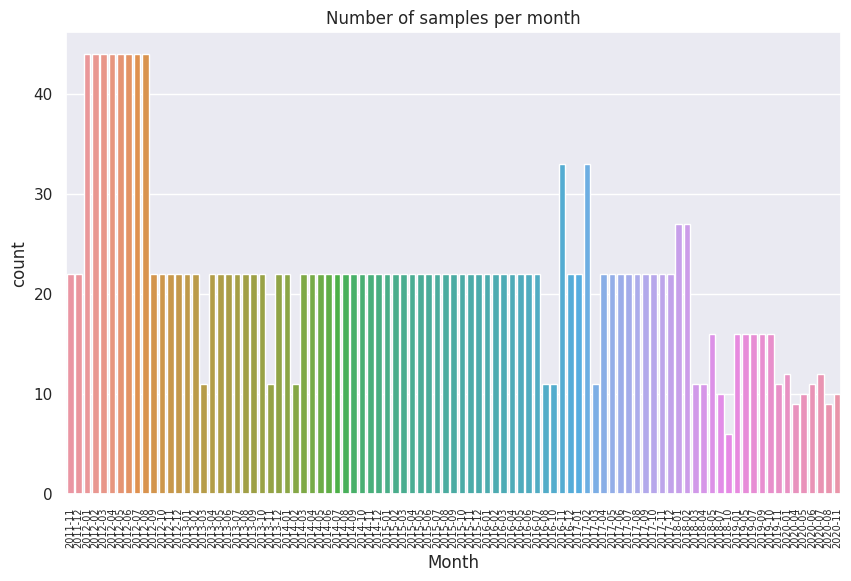

In [38]:
df['Month'] = df['Date'].dt.to_period('M') # Extracting month from Date

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Month')
plt.title('Number of samples per month')
plt.xticks(rotation=90, fontsize=7)
plt.show()

Except for the spikes aroud the year of 2012, it seems that the amount of samples being taken remains reasonably stable, so we shouldn't worry too much about the quality of the frequency of the data. Now, let's get an idea of the general distribution of the values.

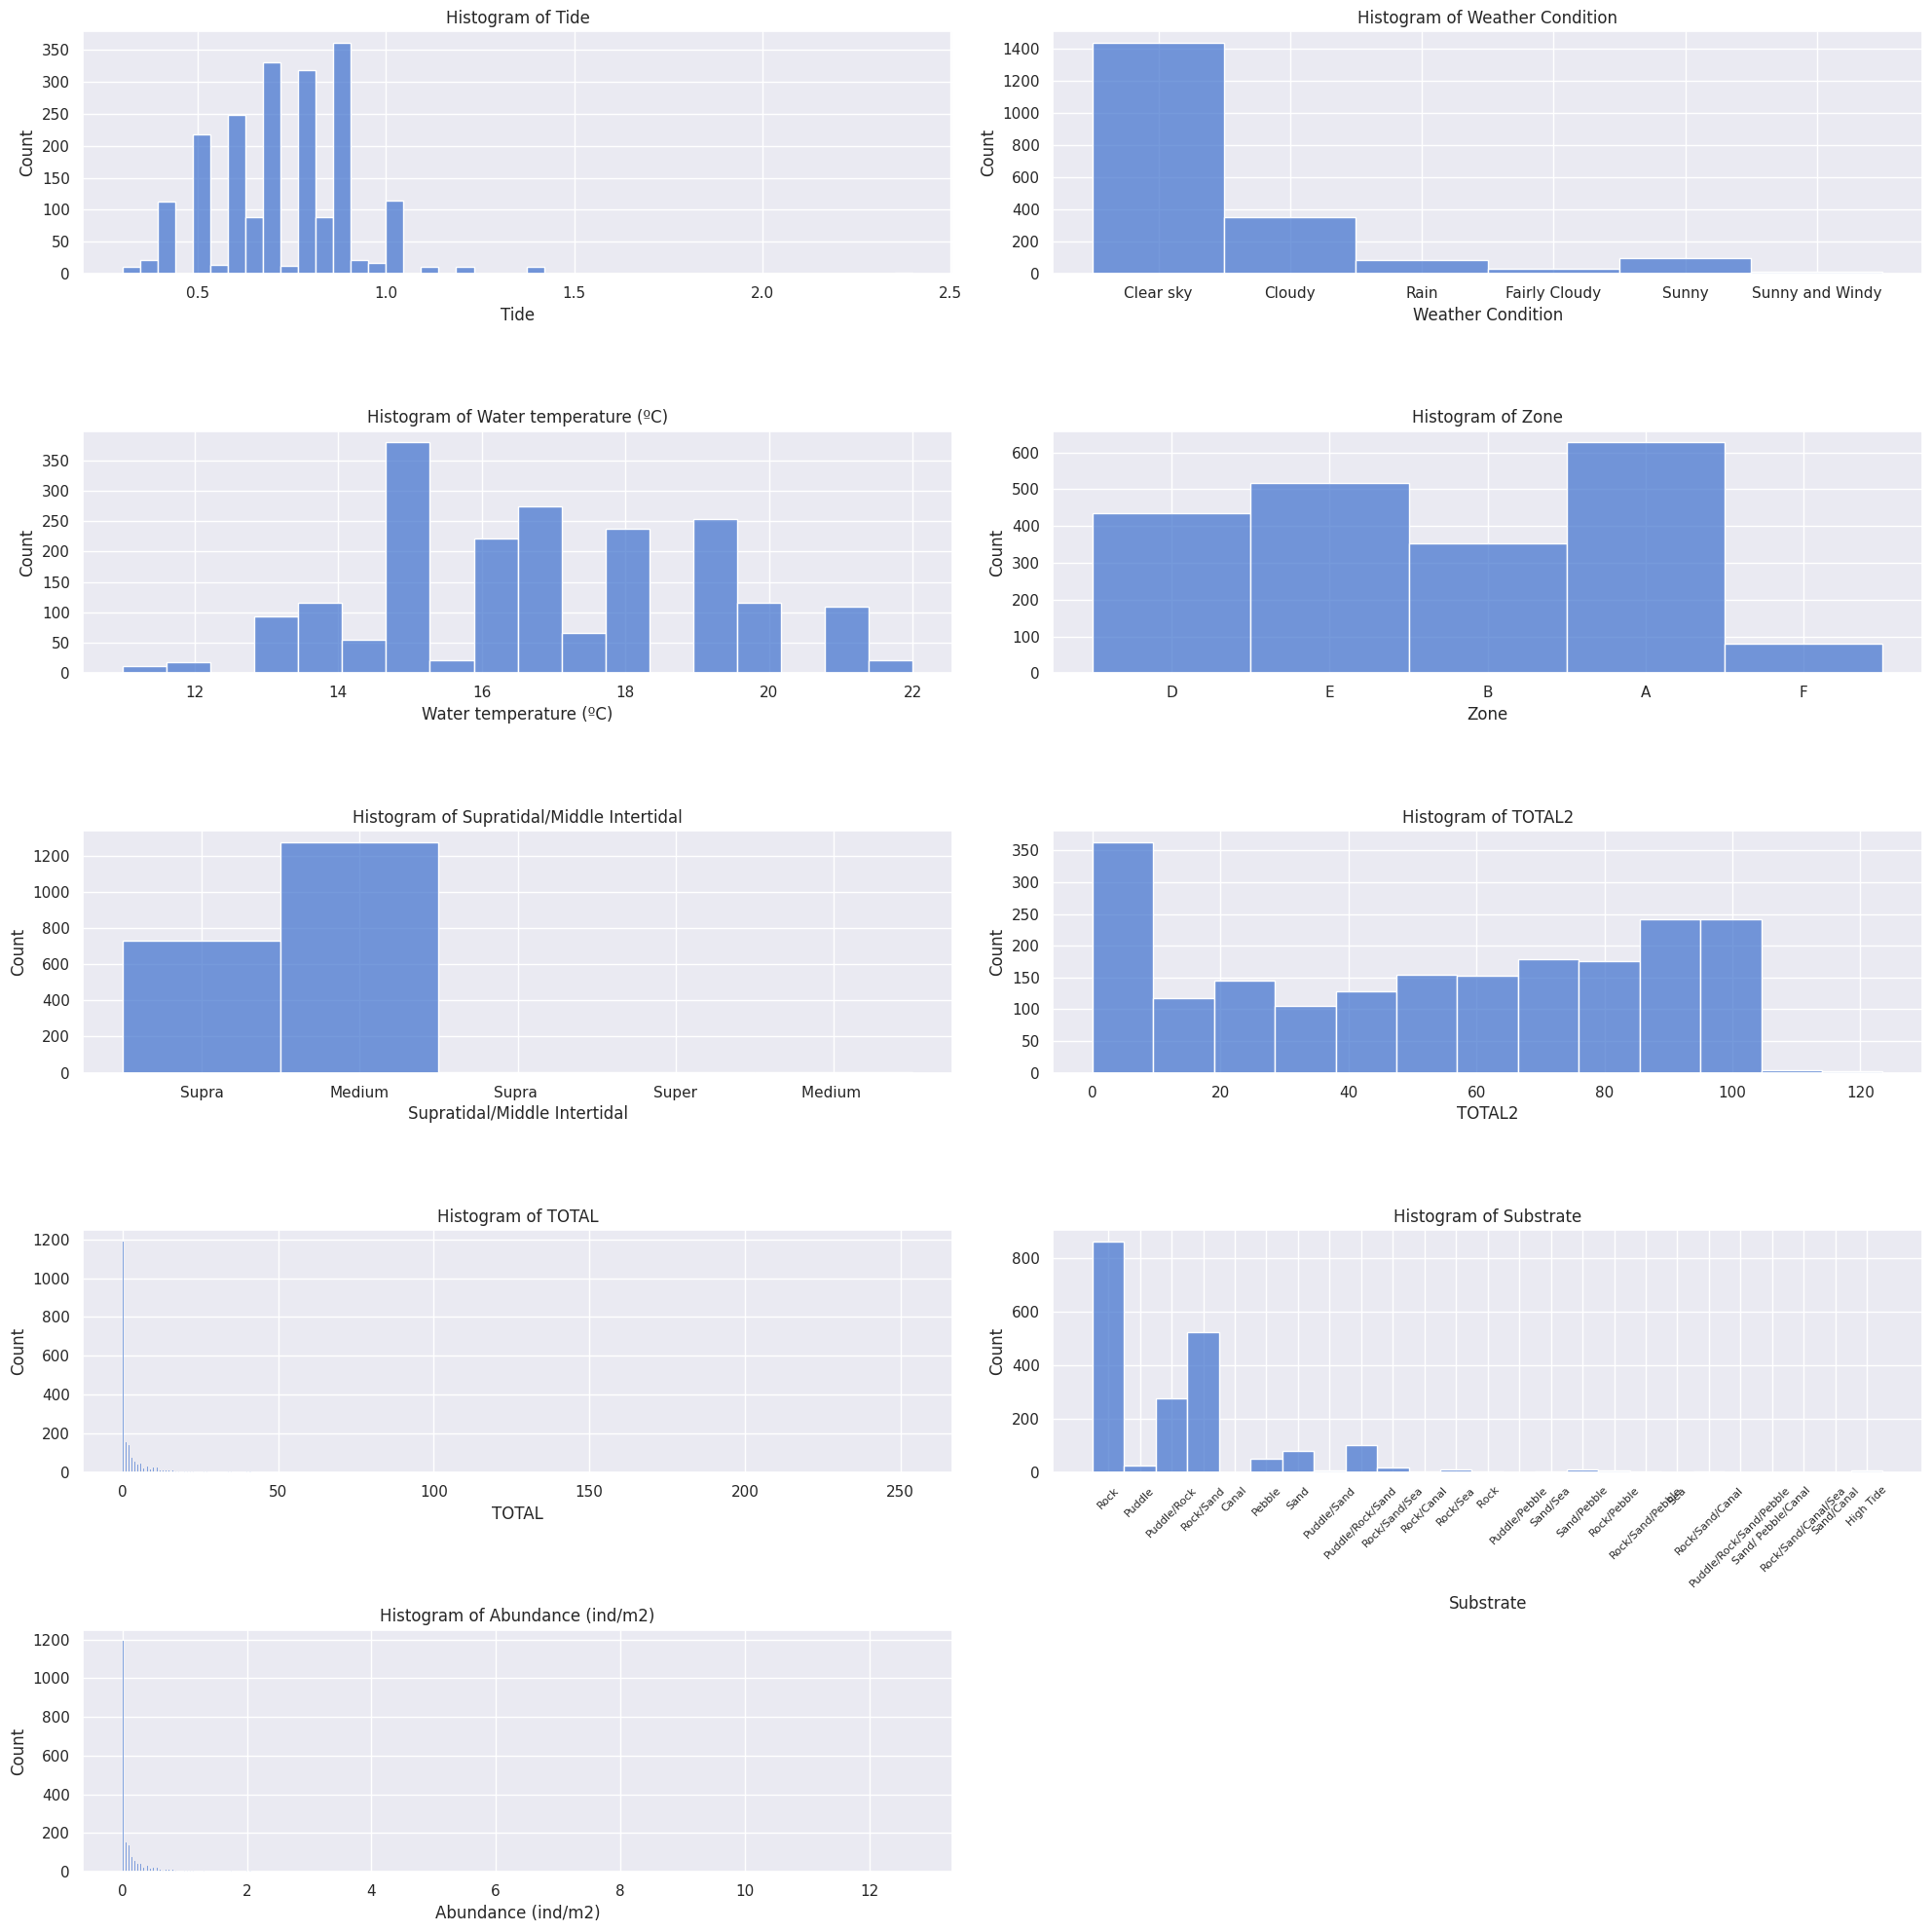

In [39]:
columns = ['Tide', 'Weather Condition', 'Water temperature (ºC)',
           'Zone', 'Supratidal/Middle Intertidal', 'TOTAL2',
           'TOTAL', 'Substrate', 'Abundance (ind/m2)']

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(5, 2)

for i, column in enumerate(columns):
    ax = plt.subplot(gs[i])
    sns.histplot(data=df, x=column, ax=ax)
    ax.set_title('Histogram of ' + column)
    if column == 'Substrate':
        plt.xticks(rotation=45, fontsize=8)
    plt.tight_layout()

plt.show()

Quite a few things to note:
- Again, the tide values seem to be OK.
- It may be useful to group some of the weather conditions and some of the substrates.
    - It seems that it may make sense to create groups.
    - For example good and bad weather for the weather condition, and Rock, Puddle, and Sand for the substrate
    - The general idea remains, and we reduce the complexity that these features may possess.
    - In this case, it would be complexity that would be difficult to deal with. With each added degree of freedom, there aren't many samples to contribute towards them, so the feature space becomes very sparse. This makes it harder for any model to learn (the curse of dimensionality).
- Zone F has considerably fewer samples than other zones.
- Some rows have a slight variantion when it comes to the Supratidal/Middle Intertidal inputs that needs to be fixed.
- Sometimes the percentage of coverage (TOTAL2) is higher than 100%, and that's OK - from the Q&A, it means that some species overlapped.
- TOTAL (number of mobil species) and Abundace (density of mobil species) seem to have large tails, but as they are related, and they both have large tails, it gives us more confidence that they are correct (assuming someone inputed the values). Nevertheless, the maximum values, although outliers, don't seem like anomalies.

Let's fix the Supra/Middle issue and carry out the groupings.

#### Fixing Speeling issues with Supra/Middle Intertidal column

In [40]:
values_and_counts_supra_middle = df['Supratidal/Middle Intertidal'].value_counts()
print(values_and_counts_supra_middle)

Medium     1276
Supra       730
Supra         2
Super         1
Medium        1
Name: Supratidal/Middle Intertidal, dtype: int64


In [41]:
values_and_counts_supra_middle.index[0]

'Medium'

In [42]:
values_and_counts_supra_middle.index[1]

'Supra'

In [43]:
values_and_counts_supra_middle.index[2]

'Supra '

The most commonly written forms are spelled without any extra spacing.

In [44]:
replacements = {values_and_counts_supra_middle.index[2]: values_and_counts_supra_middle.index[1], # supra
                values_and_counts_supra_middle.index[3]: values_and_counts_supra_middle.index[1], # supra
                values_and_counts_supra_middle.index[4]: values_and_counts_supra_middle.index[0]} # medium
df['Supratidal/Middle Intertidal'] = df['Supratidal/Middle Intertidal']\
    .replace(replacements)

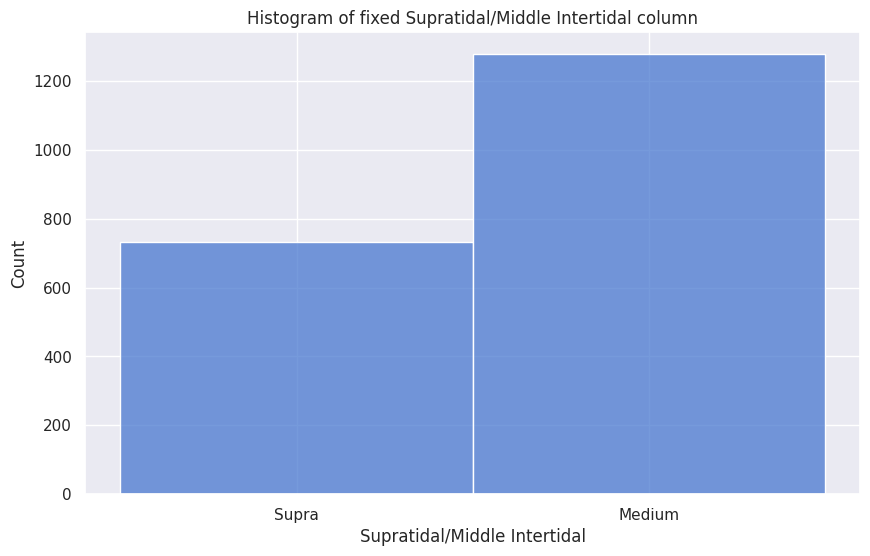

In [45]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Supratidal/Middle Intertidal')
plt.title('Histogram of fixed Supratidal/Middle Intertidal column')
plt.show()

Perfect! 👌

#### Grouping Weather Conditions and Substrate

##### Weather Condition

In [46]:
df['Weather Condition'].value_counts()

Clear sky          1437
Cloudy              351
Sunny                97
Rain                 83
Fairly Cloudy        33
Sunny and Windy       9
Name: Weather Condition, dtype: int64

In [47]:
def weather_group(weather):
    if pd.isna(weather):  # Handle NaN or None values
        return 'Unknown'
    elif 'Clear sky' in weather:
        return 'Good'
    elif 'Sunny' in weather:
        return 'Good'
    elif 'Sunny and Windy' in weather:
        return 'Good'
    else:
        return 'Bad'

In [48]:
df['Weather Condition'] = df['Weather Condition'].apply(weather_group)

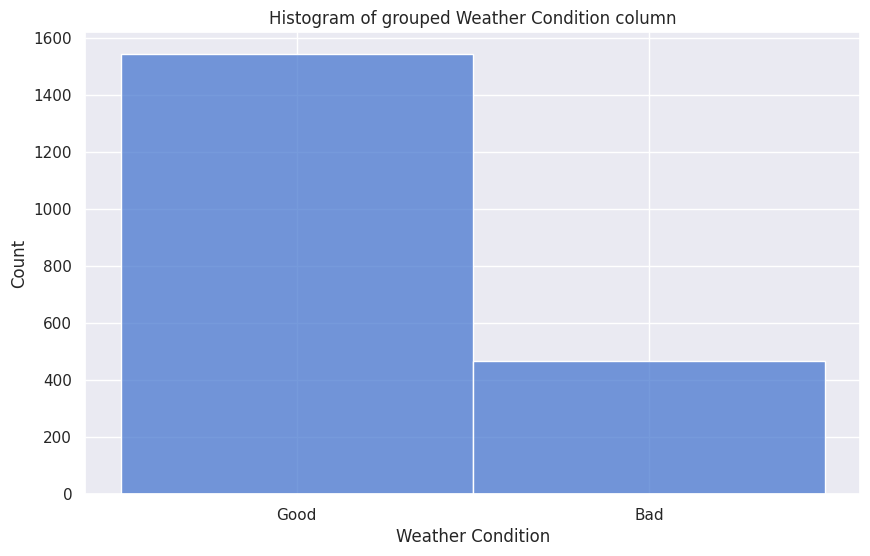

In [49]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Weather Condition')
plt.title('Histogram of grouped Weather Condition column')
plt.show()

##### Substrate

In [50]:
df['Substrate'].value_counts()

Rock                       860
Rock/Sand                  523
Puddle/Rock                275
Puddle/Rock/Sand           101
Sand                        78
Pebble                      49
Puddle                      26
Rock/Sand/Sea               17
Sand/Pebble                 12
Rock/Sea                    11
Rock/Pebble                  8
High Tide                    7
Puddle/Sand                  7
Rock/Sand/Pebble             5
Rock/Canal                   4
Sand/Sea                     4
Rock/Sand/Canal              4
 Rock                        2
Puddle/Pebble                1
Canal                        1
Sea                          1
Puddle/Rock/Sand/Pebble      1
Sand/ Pebble/Canal           1
Rock/Sand/Canal/Sea          1
Sand/Canal                   1
Name: Substrate, dtype: int64

In [51]:
substrate_key_words = df['Substrate'].value_counts().index

In [52]:
substrates_list = []
for key_words in substrate_key_words:
    key_word_lst = key_words.split('/')
    for key_substrate in key_word_lst:
        if len(key_substrate) > 1:
            substrates_list.append(key_substrate)
print(f"Relevant substrates: \n {pd.unique(substrates_list)}")

Relevant substrates: 
 ['Rock' 'Sand' 'Puddle' 'Pebble' 'Sea' 'High Tide' 'Canal' ' Rock'
 ' Pebble']


In [53]:
import random
def substrate_group(substrate):
    """
    For each word in substrate, add that word to a list.
    At the end, return a random word from that list.
    """
    substrate_list = []
    if pd.isna(substrate):  # Handle NaN or None values
        return 'Unknown'
    if 'Rock' in substrate:
        substrate_list.append('Rock')
    if 'Sand' in substrate:
        substrate_list.append('Sand')
    if 'Puddle' in substrate:
        substrate_list.append('Puddle')
    if 'Pebble' in substrate:
        # Let's consider Pebble a type of Rock as they are essentially many rocks together
        # Not ideal, but hopefully reasonable
        substrate_list.append('Rock')
    
    if len(substrate_list) == 0:
        substrate_list.append('Other')

    # If this is not done
    # There's a very large bias towards 'Rock'
    while len(substrate_list) > 1 and 'Rock' in substrate_list:
        substrate_list.remove('Rock')

    return random.choice(substrate_list)

In [54]:
df['Substrate'] = df['Substrate'].apply(substrate_group)

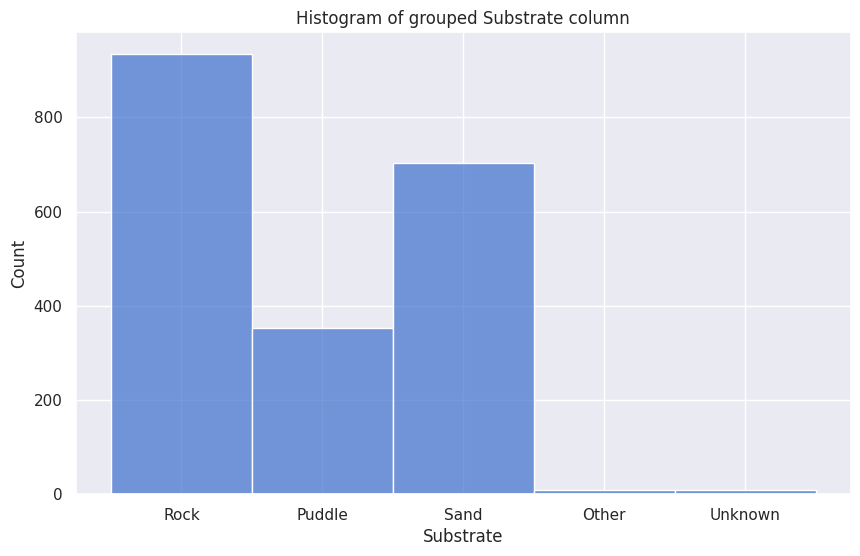

In [55]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Substrate')
plt.title('Histogram of grouped Substrate column')
plt.show()

Not exactly perfect, but better! Let's drop the 'Other' and the 'Unknowns', they're very rare (histogram after the operation in Visualizations).

In [56]:
values_to_drop = ['Other', 'Unknown']
df = df[~df['Substrate'].isin(values_to_drop)]

#### Sneaky Zone F

Let's also get an idea of how many samples are taken each month (on average) for each different Zone/Sector.

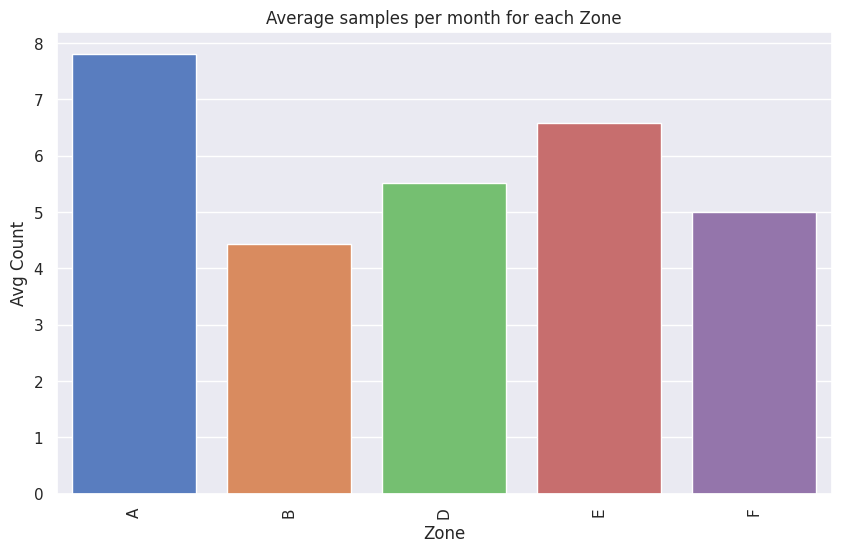

In [57]:
# Group by both 'Zone' and 'Month' and calculate average
monthly_samples = df.groupby(['Zone', 'Month']).size()\
    .groupby(['Zone']).mean().reset_index(name='Avg Count')

plt.figure(figsize=(10,6))
sns.barplot(data=monthly_samples, x='Zone', y='Avg Count')
plt.title('Average samples per month for each Zone')
plt.xticks(rotation=90)
plt.show()

This is interesting and a bit unexpected. This would make sense if the samples from Zone F only started being taken after some time had passed. And when they started being taken, the frequency was similar to the other Zones. Let's check that with the earliest date for Zone F.

In [58]:
earliest = df[df['Zone'] == 'F']['Date'].min()
latest = df[df['Zone'] == 'F']['Date'].max()
print(f"Earliest record of a sample from Zone F: {earliest}")
print(f"Latest record of a sample from Zone F: {latest}")

Earliest record of a sample from Zone F: 2018-01-18 00:00:00
Latest record of a sample from Zone F: 2020-11-16 00:00:00


As expected, samples from Zone F only started being taken after 2018 (even though samples were being taken as early as 2011). Considering this, ideally we would train two models. One without Zone F, from the data starting from 2011. And another with all of the Zones' different data, starting from 2018. For now, we'll only do the first version, as it should be the easiest one, i.e. having the most amount of data, and the least complexity.

So, let's drop the rows that have the Zone F. (Histogram to sanity check in the Visualizations tab)

In [59]:
df = df[~df['Zone'].isin(['F'])]

#### Analysing Observations

Let's look at the top observations available.

In [60]:
top_observations = df['observações'].value_counts().nlargest(6)
print(f"Top 6 most common observations: \n{top_observations}")

Top 6 most common observations: 
0                           265
muita areia                  15
postura de areia             12
tubos de Sabellaria          10
Mini caracol negro: 0,1       5
zona de cimento (trilho)      5
Name: observações, dtype: int64


One of the observations is just "0", probably a filler value that we can ignore.

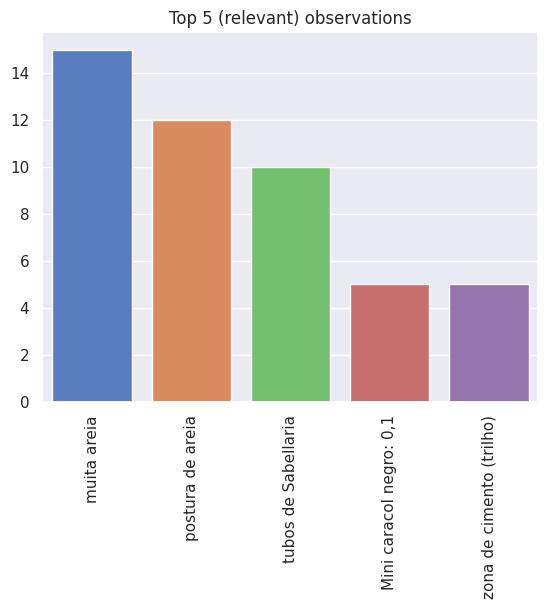

In [61]:
# Plot histogram of top 3 observations
sns.barplot(x=top_observations[1::].index, y=top_observations[1::].values)
plt.title('Top 5 (relevant) observations')
plt.xticks(rotation=90)
plt.show()

It's rare that there are relevant observations available (considering that there around 1900 rows), and, it's not exactly clear how these observations influence the rest of the data. Considering that, a safe and easy to implement option to deal with this data is to remove the observations column.

In [62]:
df.drop(['observações'], axis=1, inplace=True)

#### Conclusions on the analysis of the values of the meta information

- Changed data types of 'Weather Temperature (ºC)' and other columns
- Fixed Speeling (hehe) issues with Supra/Middle Intertidal column
- Grouped Weather Condtions and Substrate
- Reasoned about whether or not to keep samples from Zone F; removed them
- Removed (with justification) the observations column

Now, let's go over the actual species values!

#### Analysis of the distribution of values of the Sessil species % coverage

Let's start by looking at how often the values are zero, and, when they're not zero, what are their usual distribution.

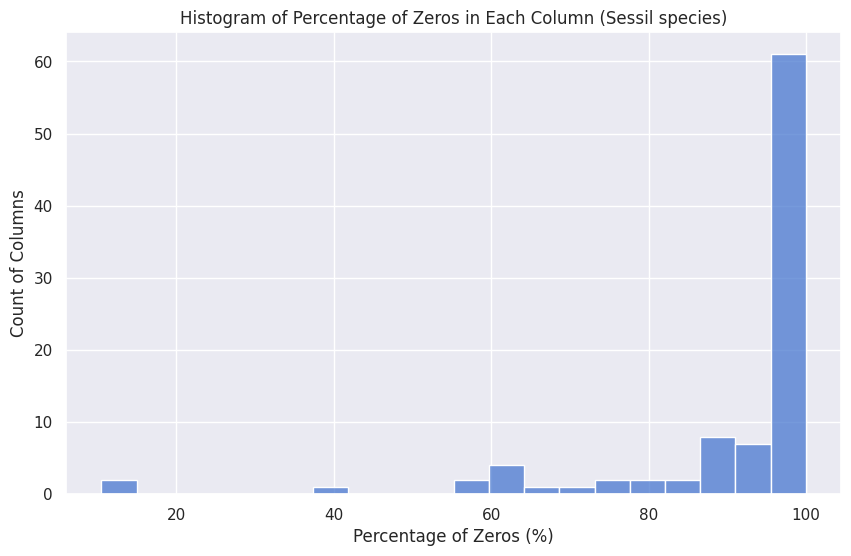

In [63]:
# Calculate the percentage of zeros for each column and save it to a list
percentage_zeros = [(df[col] == 0).mean() * 100 for col in sessil_species_columns]

# Plot a histogram of the percentage of zeros
plt.figure(figsize=(10,6))
sns.histplot(percentage_zeros, bins=20, kde=False)
plt.title('Histogram of Percentage of Zeros in Each Column (Sessil species)')
plt.xlabel('Percentage of Zeros (%)')
plt.ylabel('Count of Columns')
plt.show()

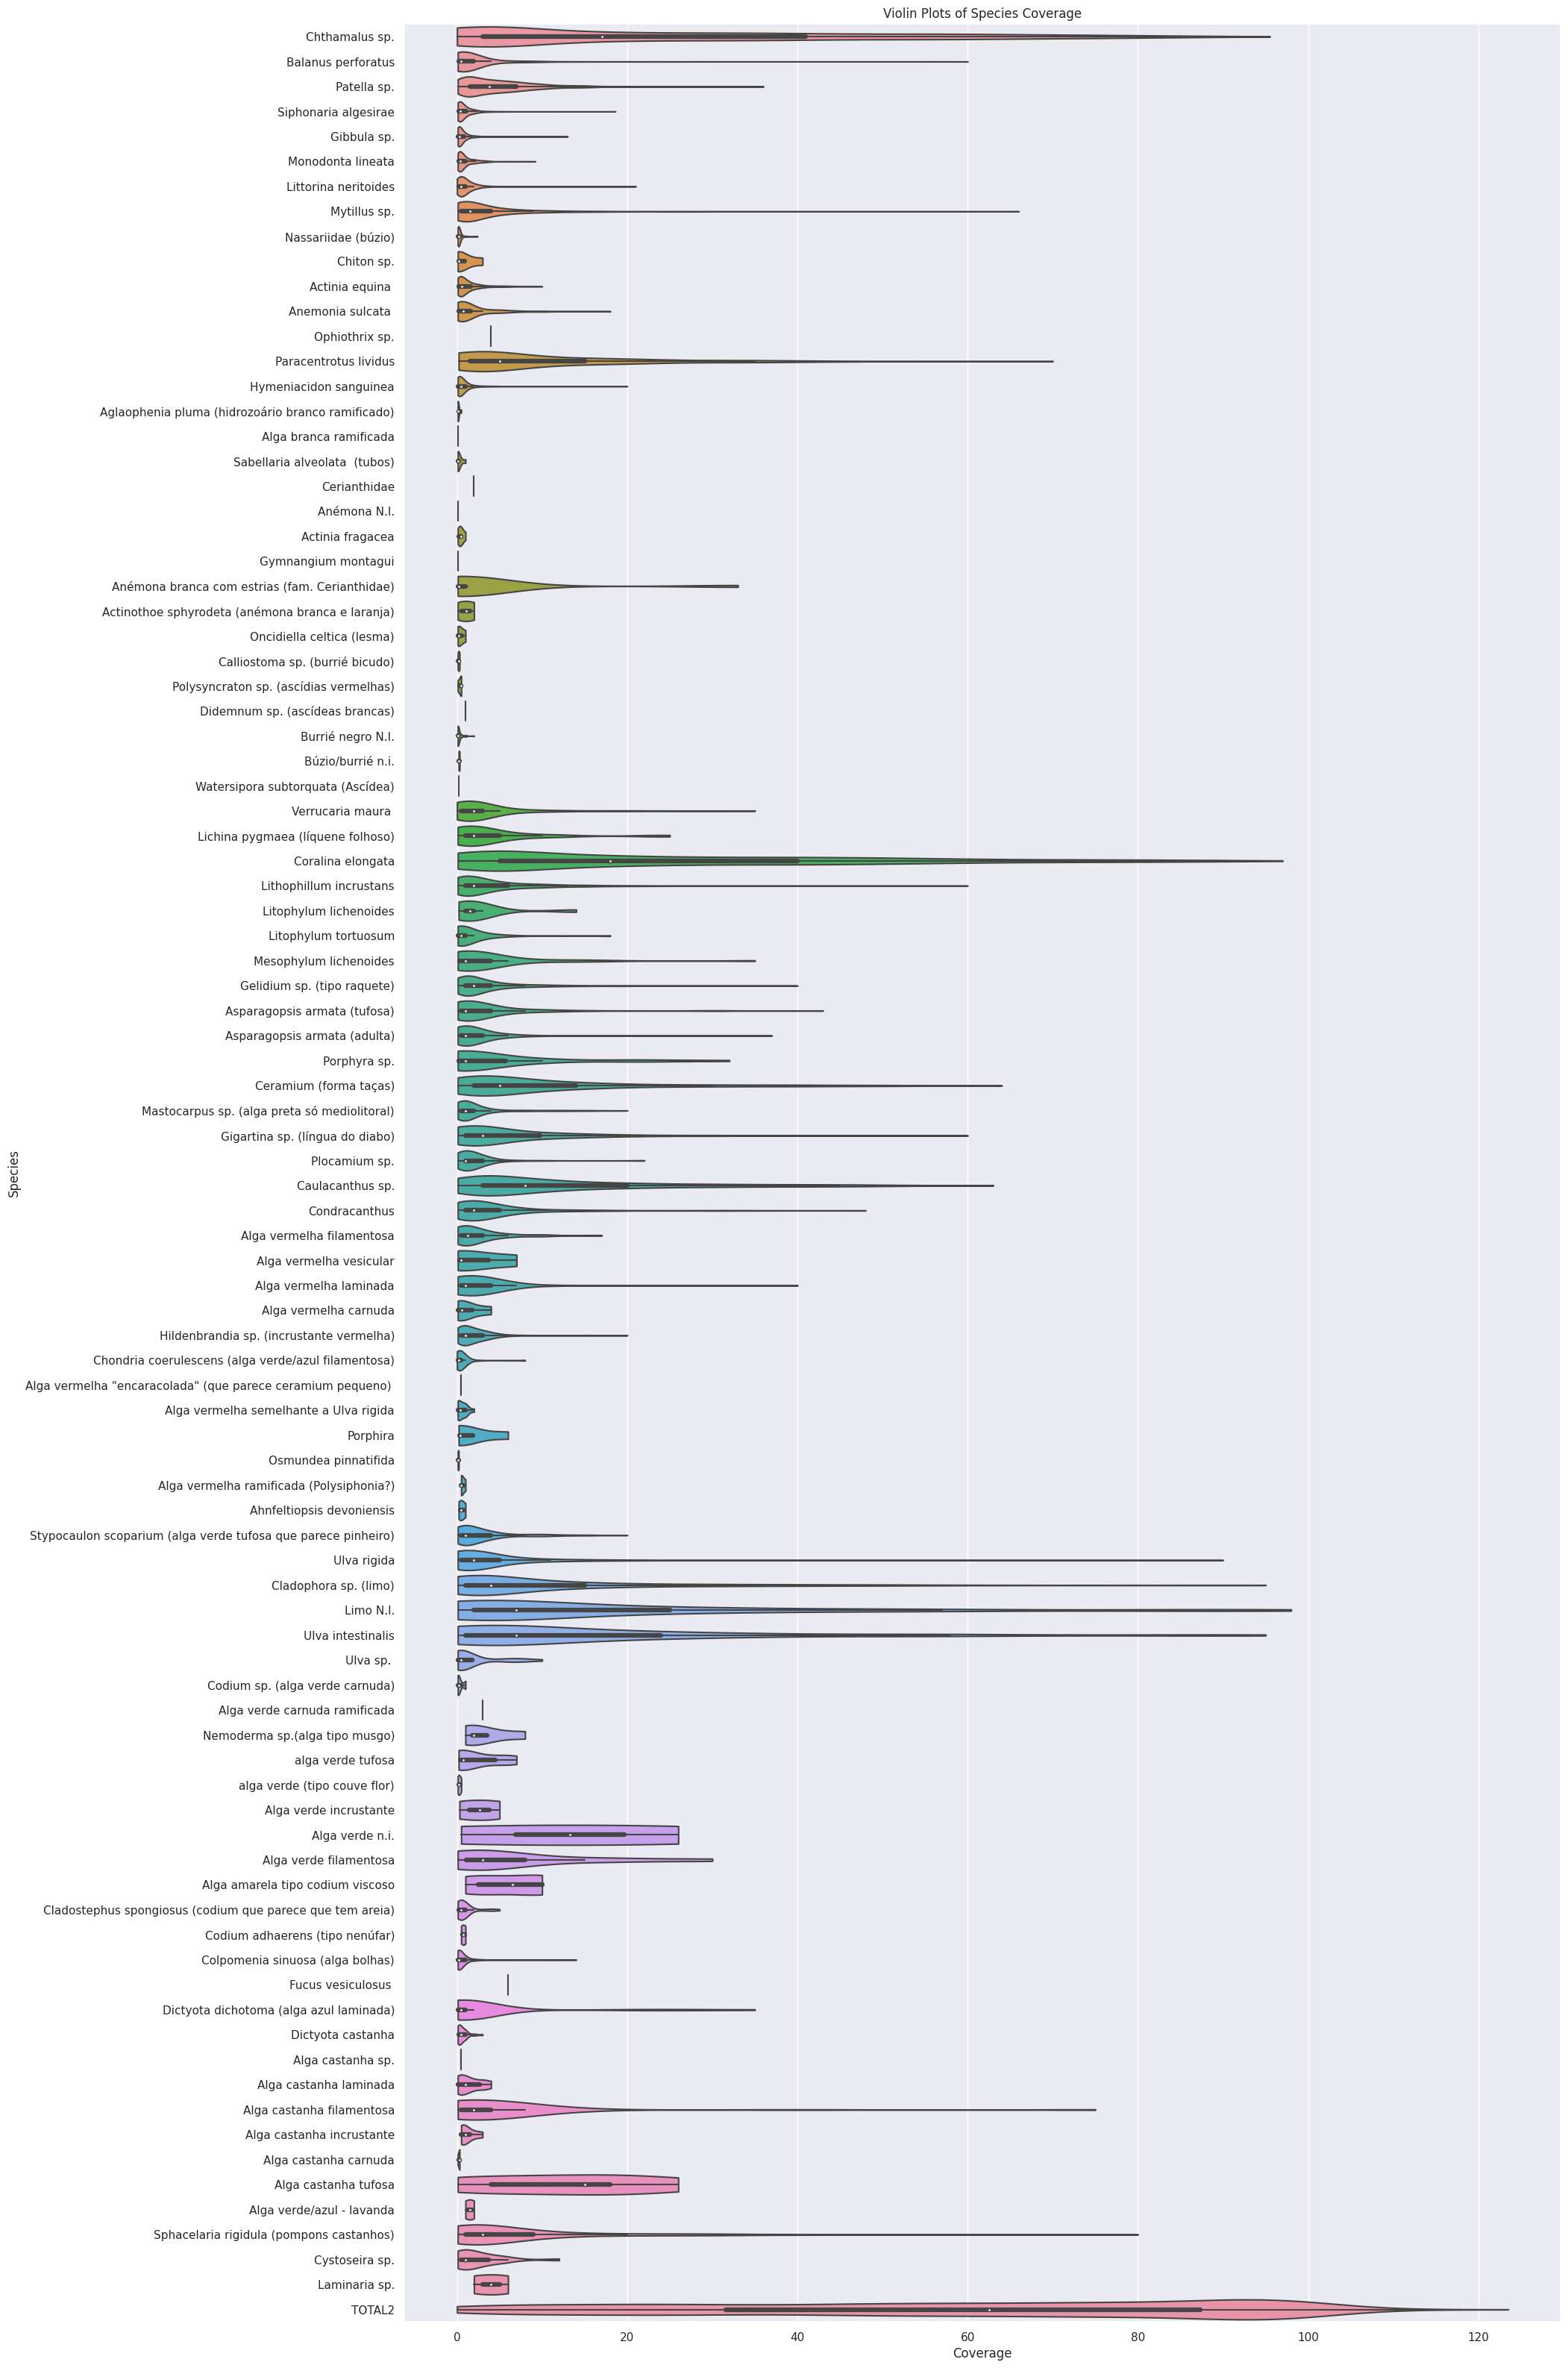

In [64]:
# Reshape to long format. Assuming df is your dataframe.
df_melted = df[sessil_species_columns].melt(var_name='Species', value_name='Coverage')

# Convert the 'Coverage' column to a numeric data type
df_melted['Coverage'] = pd.to_numeric(df_melted['Coverage'], errors='coerce')

# Remove zero values
df_melted = df_melted[df_melted['Coverage'] != 0]

# Increase the size of the plot
plt.figure(figsize=(20, 40))

# Create violin plot
sns.violinplot(data=df_melted, y='Species', x='Coverage', scale='width', cut=0)

# Show the plot
plt.title('Violin Plots of Species Coverage')
plt.show()

- Often, the value for coverage for most species is 0. I.e., often most of the species are not found (which makes sense).
- Interestingly, but unfortunately for us, often we're dealing with very long tails. These are usually harder to model.
- Note that for certain species, it's very rare (happening sometimes once even) to have any coverage (we can see this in the violin plots where there's no clear distribution, only a dash).
- All of the medians are below 20%, often below 10%. So most of the times, if there is any specie in a quadrat, it's only covering a small part of it.
- In some rare occasions, some species occupied most of the quadrat.
- Often, there is some coverage of the quadrat, with the median slightly above 60% (TOTAL2)

After manually going through all of the sessil species, it was found that there were no repeated ones. However, it seemed like often a specie had referece to another specie, such as "similar to X" or "like Y".

Plus, very often, as shown by above, columns are often mostly zeroes. If we were to try to model this, it would likely be quite hard, as we would **probably** be dealing with very random patterns for the large majority of the classes. I.e., a specie would often be zero, and then have a sporadic jump. Predicting this sporadic jump would **probably** be quite difficult, since we're dealing with a random quadrat in a certain Zone. Furthermore, we're dealing with distributions that have quite long tails. We ought to reduce the complexity of this a bit, to ensure that modeling may work reasonably well...

##### Analysing missing values

In [65]:
# Calculate the number of missing values in each column
missing_values = df[sessil_species_columns].isnull().sum()

# Convert Series to DataFrame for seaborn
missing_values_df = missing_values.reset_index()
missing_values_df.columns = ['Column', 'Missing Values']

missing_values_df[missing_values_df['Missing Values'] == missing_values_df['Missing Values'].max()]

,Column,Missing Values
31,Watersipora subtorquata (Ascídea),1637


Interestingly, one specific column had a very large amount of missing values. Since we're dealing with over 80% missing values (1640/1900), we'll just drop that particular specie.

In [66]:
# Drop really large missing values column
df = df.drop('Watersipora subtorquata (Ascídea)', axis=1)

In [67]:
# Update species list
sessil_species_columns.remove('Watersipora subtorquata (Ascídea)')

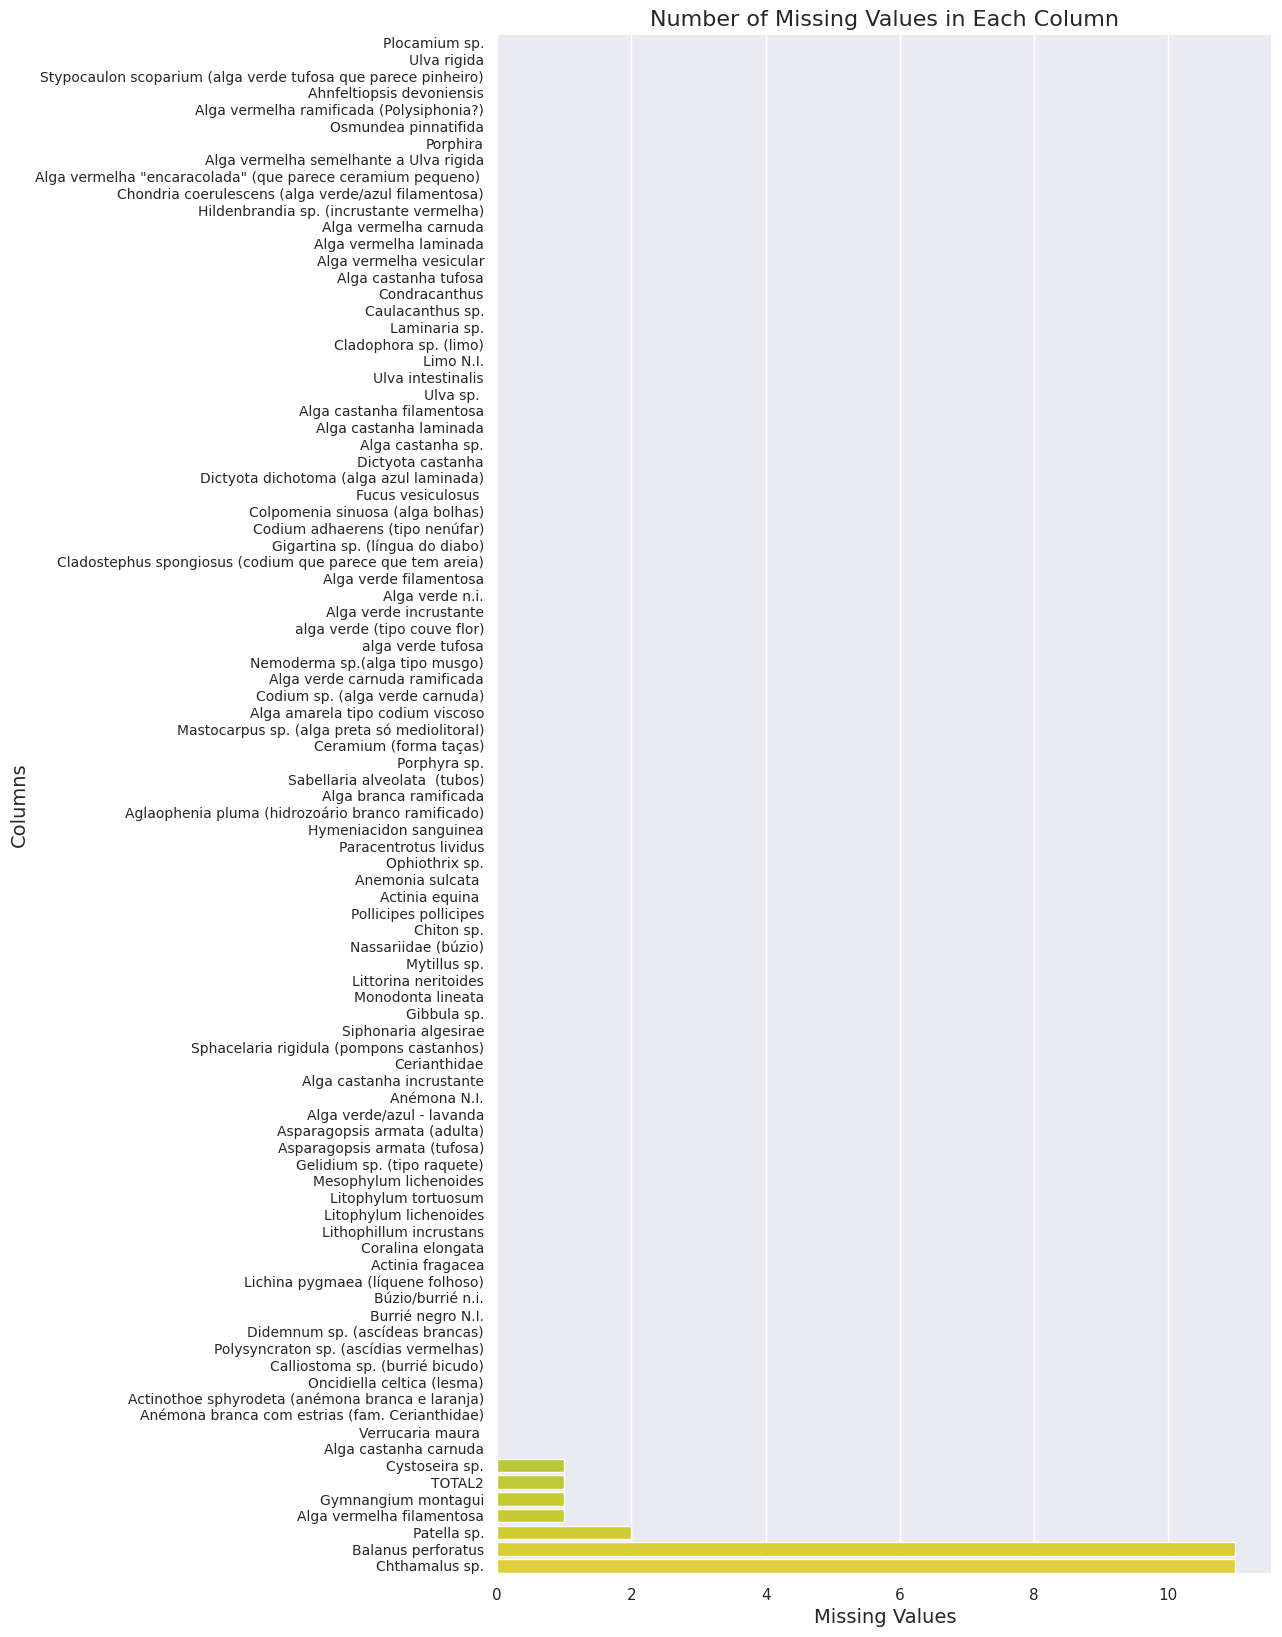

In [68]:
# Re-Calculate the number of missing values in each column
missing_values = df[sessil_species_columns].isnull().sum()

# Convert Series to DataFrame for seaborn
missing_values_df = missing_values.reset_index()
missing_values_df.columns = ['Column', 'Missing Values']

# Sort DataFrame by number of missing values
missing_values_df = missing_values_df.sort_values(by='Missing Values', ascending=True)

# Create seaborn barplot
plt.figure(figsize=(10, 20))  # adjust size as needed
sns.barplot(x='Missing Values', y='Column', data=missing_values_df, palette='viridis')

plt.title('Number of Missing Values in Each Column', fontsize=16)
plt.xlabel('Missing Values', fontsize=14)
plt.ylabel('Columns', fontsize=14)
plt.yticks(fontsize=10)  # adjust fontsize as needed

plt.show()

No other columns has a particularly large number of missing values. We'll deal with these missing values by filling them with the previous value (after we order the df by DateTime).

In the visualizations you can find the same plots but for the Mobil species.

For the Mobil species, it was found that there is one repeated column that has to be removed ('Acanthochitona fascicularis'), and that there are some species that were never seen (the count value was always zero).

Then it was found that there was a particular period where there were missing values for essentially all of the mobil species (100% overlap of missing values accross columns). In order to not lose the sessile species information, those values will be imputed with the previous value. Despite being a reasonably large number (around 40), this seemed borderline reasonable.

In [69]:
df = df.drop('Acanthochitona fascicularis', axis=1)
mobil_species_columns.remove('Acanthochitona fascicularis')

#### Dealing with missing values

Let's just check the meta info columns...

In [70]:
sessil_meta_columns.remove("observações")

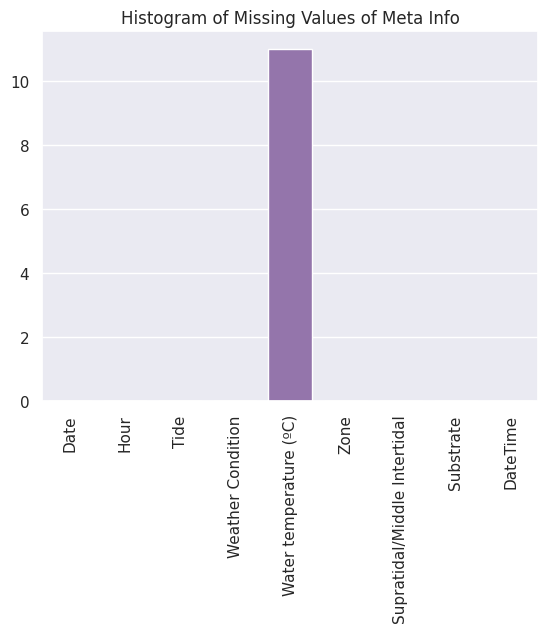

In [71]:
missing_values_meta = df[sessil_meta_columns].isnull().sum()
sns.barplot(x=missing_values_meta.index, y=missing_values_meta)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Histogram of Missing Values of Meta Info')
plt.show()

There also seem to be some missing values with those, but it's a reasonable amount!

Except for TOTAL, TOTAL2 (which we can calculate the value that it should be), let's fill in missing values with the value before it, after organizing the df according to DateTime, Zone, and Tidal location.

There's a chance that we'll select a value that doesn't belong to the same Zone, but it at least should be to the closest Zone.

Then, we'll calculate TOTAL, TOTAL2.

In [72]:
# Sort by 'DateTime' and 'Zone' columns
df.sort_values(by=['DateTime', 'Zone', 'Supratidal/Middle Intertidal'], inplace=True)

# Get all columns except 'TOTAL2' and 'TOTAL'
columns_to_fill = [col for col in df.columns if col != 'TOTAL2' and col != 'TOTAL']

# Fill missing values with previous ones
df[columns_to_fill] = df[columns_to_fill].fillna(method='ffill')

Now we just have to do some imputation surgery, to deal with the remaining missing values...

In [73]:
# Get the columns with missing values
columns_with_missing_values = df.columns[df.isnull().any()]

# Print the columns with missing values
print(columns_with_missing_values)

Index(['Balanus perforatus', 'TOTAL2', 'TOTAL'], dtype='object')


In [74]:
df[df['Balanus perforatus'].isnull()]

,Date,Hour,Tide,Weather Condition,Water temperature (ºC),Zone,Supratidal/Middle Intertidal,Substrate,Chthamalus sp.,Balanus perforatus,...,Callionymus lira (peixe-pau lira),Oncidiella celtica,Doriopsilla areolata (nudibrânquio),Scorpaena sp. (Rascasso),Lipophrys pholis (ad.),Diplodus cervinus,Gobiusculus flavescens,TOTAL,Abundance (ind/m2),Month
2,2011-11-28,10:10:00,0.6,Good,16.0,D,Medium,Puddle,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.2,2011-11


In [75]:
df['Balanus perforatus'].loc[2] = df['Balanus perforatus'].loc[1]

/tmp/ipykernel_7306/1678626034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Balanus perforatus'].loc[2] = df['Balanus perforatus'].loc[1]


In [76]:
just_sessil_species = [item for item in sessil_species_columns if item not in ['TOTAL2']]

In [77]:
just_mobil_species = [item for item in mobil_species_columns if item not in ['TOTAL', 'Abundance (ind/m2)']]

In [78]:
df['TOTAL2'] = df['TOTAL2'].fillna(df[just_sessil_species].sum(axis=1))
df['TOTAL'] = df['TOTAL'].fillna(df[just_mobil_species].sum(axis=1))

In [79]:
print("Number of missing values: ", df.isnull().sum().sum())

Number of missing values:  0


There we have it! Our base dataset is ready to move on to feature engineering and modeling.

In [80]:
df

,Date,Hour,Tide,Weather Condition,Water temperature (ºC),Zone,Supratidal/Middle Intertidal,Substrate,Chthamalus sp.,Balanus perforatus,...,Callionymus lira (peixe-pau lira),Oncidiella celtica,Doriopsilla areolata (nudibrânquio),Scorpaena sp. (Rascasso),Lipophrys pholis (ad.),Diplodus cervinus,Gobiusculus flavescens,TOTAL,Abundance (ind/m2),Month
2,2011-11-28,10:10:00,0.6,Good,16.0,D,Medium,Puddle,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.20,2011-11
3,2011-11-28,10:25:00,0.6,Good,16.0,D,Medium,Rock,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.10,2011-11
4,2011-11-28,10:40:00,0.6,Good,16.0,D,Medium,Rock,25.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.05,2011-11
7,2011-11-28,11:00:00,0.6,Good,16.0,E,Medium,Rock,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.10,2011-11
8,2011-11-28,11:15:00,0.6,Good,16.0,E,Medium,Rock,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2011-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000,2020-11-16,08:00:00,0.4,Good,18.0,D,Medium,Sand,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.10,2020-11
2001,2020-11-16,08:00:00,0.4,Good,18.0,D,Medium,Sand,36.0,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.10,2020-11
2002,2020-11-16,08:00:00,0.4,Good,18.0,D,Medium,Rock,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.10,2020-11
2003,2020-11-16,08:00:00,0.4,Good,18.0,D,Supra,Rock,71.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2020-11


#### Studying the effect of Air Polution

An interesting feature to add, would be one that helps describe anthropogenic stress. A good way to do so is with air quality, as the presence of humans, especially near urban areas, as is the case with Avencas, usually results in worse air quality. Unfortunately, it was not possible to get air quality data for the entire duration of the dataset, thus it wasn't added to the final modeling dataset. But we can still plot some correlation charts to get an idea if it would be a good addition in the future...

##### Getting the Air Quality data

In [81]:
import requests
import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the Earth in kilometers

    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

def get_locations(country):
    response = requests.get(f'https://api.openaq.org/v1/locations',
                            params={
                                'country': country,
                                'limit': 1000  # get up to 1000 locations
                            })
    data = response.json()
    return data

def get_air_quality(sensor_id, date_from, date_to):
    response = requests.get(f'https://api.openaq.org/v1/measurements',
                            params={
                                'location': sensor_id,
                                'date_from': date_from,
                                'date_to': date_to,
                                'limit': 1000  # get up to 1000 measurements
                            })
    data = response.json()
    return data

In [82]:
# Get information on air quality sensors in Portugal
country = 'PT'
locations_data = get_locations(country)

sensors = [
    {
        'id': result['id'],
        'location': result['location'],
        'latitude': result['coordinates']['latitude'],
        'longitude': result['coordinates']['longitude']
    }
    for result in locations_data['results']
]

# Avencas
lat1 = 38.689100
lon1 = -9.360120

# Find the nearest sensor
nearest_sensor = min(sensors, key=lambda sensor: haversine(lat1, lon1,
                                                           sensor['latitude'],
                                                           sensor['longitude']))

sensor_id = nearest_sensor['location']
date_from = '2011-11-28T10:10:00'  # df['DateTime'].min()
date_to = '2020-11-16T08:00:00'  # df['DateTime'].max()
air_quality_data = get_air_quality(sensor_id, date_from, date_to)

df_airqual = pd.DataFrame(air_quality_data['results'])

# Convert the date column into two separate columns for UTC and local dates
df_airqual[['date_utc', 'date_local']] = df_airqual['date'].apply(pd.Series)

# Drop the original date column
df_airqual = df_airqual.drop('date', axis=1)

# Pivot the DataFrame
df_airqual_pv = df_airqual.pivot(index='date_local', columns='parameter', values='value')

In [83]:
df_airqual_pv = df_airqual_pv.reset_index()

In [84]:
# A lot of missing values
df_airqual_pv.drop('pm10', axis=1, inplace=True)

In [85]:
df_airqual_pv['date_local'] = pd.to_datetime(df_airqual_pv['date_local'])

In [86]:
df_airqual_pv['date_local'] = pd.to_datetime(df_airqual_pv['date_local'], utc=True)
df_airqual_pv['date_local'] = df_airqual_pv['date_local'].dt.tz_convert(None)

In [87]:
# Sort by date
df_airqual_pv = df_airqual_pv.sort_values('date_local')

# Fill missing vals
df_airqual_pv = df_airqual_pv.fillna(method='ffill')

In [88]:
# The process of getting this data is in the Annex
df_airqual_pv.head()

parameter,date_local,no2,o3
0,2020-10-18 09:00:00,12.5,53.0
1,2020-10-18 10:00:00,14.4,58.0
2,2020-10-18 11:00:00,14.8,60.0
3,2020-10-18 12:00:00,11.5,72.0
4,2020-10-18 13:00:00,9.8,88.0


##### Merging Air Quality Data

In [89]:
# So that we can make an inner join
df['DateTimeHfloor'] = df['DateTime'].dt.floor('H')

In [90]:
df_airqual_merge = df.merge(df_airqual_pv, left_on='DateTimeHfloor', right_on='date_local', how='left')
# Drop rows with missing values
df_airqual_merge = df_airqual_merge.dropna()

In [91]:
print(f"Length of the merged dataframe: {len(df_airqual_merge)}")

Length of the merged dataframe: 5


Let's be honest it ain't much. But we'll do with what we got with this one fellas :)

/tmp/ipykernel_7306/1654323499.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_airqual_merge.corr()


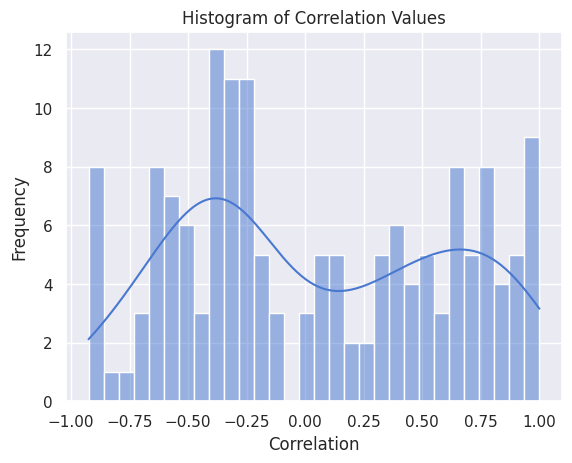

In [92]:
# Calculate the correlation
corr = df_airqual_merge.corr()

# Unstack the correlation matrix to get a series of correlation values
corr_values = corr.unstack().drop_duplicates()

# Plot a seaborn histogram of the correlation values
sns.histplot(corr_values, bins=30, kde=True)
plt.title('Histogram of Correlation Values')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()


Interestingly, there are some columns with very high correlation (although it's just 5 samples, so we need to take this with a large grain of salt)!

In [93]:
# save the processed dataframe
df.to_csv("./data/processed/processed_data.csv")

### Feature Engineering/Preparig the Dataset

#### Add distance to mid summer, and mid day

From Ferreira et al. 2017, it was understood that the seasons have a significant effect. To take this into account, two new features were added, the time distance to the middle of the summer, and to the middle of the day. 

In [94]:
### Division of the Sessil species into groups
import datetime

temp = df['Water temperature (ºC)'].values
tide = df['Tide'].values
weather = df['Weather Condition'].values
zone = df['Zone'].values
supra_middle = df['Supratidal/Middle Intertidal'].values
substrate = df['Substrate'].values

weather[weather == 'Good'] = 1
weather[weather == 'Bad'] = 0

zone[zone == 'A'] = 1
zone[zone == 'B'] = 4/5
zone[zone == 'C'] = 3/5
zone[zone == 'D'] = 2/5
zone[zone == 'E'] = 1/5
zone[zone == 'F'] = 0

supra_middle[supra_middle == 'Supra'] = 1
supra_middle[supra_middle == 'Supra '] = 1
supra_middle[supra_middle == 'Super'] = 1
supra_middle[supra_middle == 'Medium'] = 0
supra_middle[supra_middle == 'Medium '] = 1

time_to_15h_1 = [datetime.timedelta(hours = int(val[0:2]), minutes = int(val[3:5])) - datetime.timedelta(hours=15,minutes=0) for val in df['Hour']]
time_to_15h_2 = [datetime.timedelta(hours=15,minutes=0) - datetime.timedelta(hours = int(val[0:2]), minutes = int(val[3:5])) for val in df['Hour']]

time_to_15h = np.maximum(time_to_15h_1, time_to_15h_2)
time_to_15h = np.array([time.seconds for time in time_to_15h])

# 220 corresponds to 8th August in a non leap year
days_to_mid_summer_day = np.maximum(df['Date'].dt.dayofyear.values - 220, 220 - df['Date'].dt.dayofyear.values)


#### Normalizing the Data

In [95]:
from sklearn.preprocessing import MinMaxScaler

input_array = np.stack([temp, tide, weather, zone, supra_middle, time_to_15h, days_to_mid_summer_day]).T

#Contains the info for every specie:
ouput_array = np.array([df[col].values for col in df.iloc[:,8:-3].columns.values]).T

In [96]:
scaler = MinMaxScaler(feature_range=(0,1))
# fit scaler on data
scaler.fit(input_array)
# apply transform
normalized_input = scaler.transform(input_array)

# normalizing the output data

scaler = MinMaxScaler(feature_range=(0,1))
# fit scaler on data
scaler.fit(ouput_array)
# apply transform
normalized_output = scaler.transform(ouput_array)

#### Spliting the Data

In [97]:
x_train, y_train = normalized_input[:int(0.8*normalized_input.shape[0])], normalized_output[:int(0.8*normalized_input.shape[0])]
x_val, y_val = normalized_input[int(0.8*normalized_input.shape[0]):int(0.9*normalized_input.shape[0])], normalized_output[int(0.8*normalized_input.shape[0]):int(0.9*normalized_input.shape[0])]
x_test, y_test = normalized_input[int(0.9*normalized_input.shape[0]):], normalized_output[int(0.9*normalized_input.shape[0]):]

### Modeling

#### Initial Baseline

Sice we're trying to create an app that can convey the abundace of species depending on factors around, a model that can predict which species will be present given certain conditions sounds perfect for this scenario. This way, for any given set of conditions, we could estimate which specie would be present, and study the effect of changing the conditions.

Modeling this dataset seems like a daunting task, as there are few features, and a lot of classes. Still, let's give it a try. We'll implemente a simple neural network to get started. Hopefully, this neural network can capture the complex relationships that exist in a marine ecossystem.

### 1st try: Predicting the values for every single specie

In [98]:
from keras import backend as K


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

2023-05-19 12:51:53.958288: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 12:51:54.091452: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 12:51:54.092497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 12:51:54.936360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [99]:
import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

model = tf.keras.models.Sequential(
    layers=[
        tf.keras.layers.Dense(256, input_dim=x_train.shape[1], activation="relu", name="input"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation="relu", name="layer1"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation="relu", name="layer2"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation="relu", name="layer3"),
        tf.keras.layers.Dense(y_train.shape[1], name="output")
    ])

model.summary()

optimizer = tf.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss=root_mean_squared_error) 

history = model.fit(x_train, y_train,
                   validation_data=(x_val, y_val),
                   batch_size=64,
                   epochs=200,  callbacks=[callback], shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               2048      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 layer1 (Dense)              (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 layer2 (Dense)              (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 layer3 (Dense)              (None, 128)               1

Epoch 1/200
24/24 [==============================] - 1s 6ms/step - loss: 0.0671 - val_loss: 0.0630
Epoch 2/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.0616
Epoch 3/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0555 - val_loss: 0.0625
Epoch 4/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0551 - val_loss: 0.0593
Epoch 5/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0592
Epoch 6/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0544 - val_loss: 0.0593
Epoch 7/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0543 - val_loss: 0.0583
Epoch 8/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0542 - val_loss: 0.0581
Epoch 9/200
24/24 [==============================] - 0s 4ms/step - loss: 0.0539 - val_loss: 0.0588
Epoch 10/200
24/24 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0583
Epoch 11/

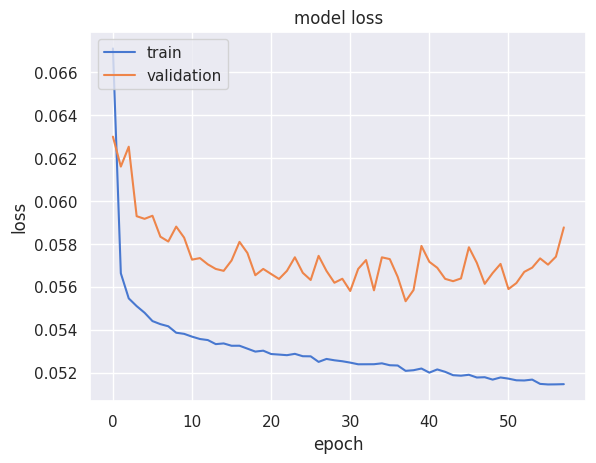

In [100]:
def plot_model(metric, history):
 plt.plot(history.history[metric])
 plt.plot(history.history[f"val_{metric}"])
 plt.title(f"model {metric}")
 plt.ylabel(f"{metric}")
 plt.xlabel("epoch")
 plt.legend(["train", "validation"], loc="upper left")
 plt.show()

plot_model("loss", history)

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

predictions = model.predict(x_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Create a table with the metrics
metrics_table = pd.DataFrame({'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R-squared (R2)'],
                             'Value': [mse, rmse, mae, r2]})

print(metrics_table)

6/6 [==============================] - 0s 834us/step
                           Metric     Value
0        Mean Squared Error (MSE)  0.004180
1  Root Mean Squared Error (RMSE)  0.064653
2       Mean Absolute Error (MAE)  0.015691
3                  R-squared (R2) -0.885894


### 2nd try: Combining output classes for less complexity

Now we will try to predict the values for the groups of species (mobile vs sessil species) instead of doing it for each single specie.

In [102]:
# Grouping species

sessil_species = np.zeros(len(df))
mobile_species = np.zeros(len(df))

for col in df.columns:

    if col in just_sessil_species:
        sessil_species += df[col]

    if col in just_mobil_species:
        mobile_species += df[col]


##### Re-normalize and split the data

In [103]:
output_array_sessil_mobil = np.stack([sessil_species, mobile_species]).T

# normalizing the output data

scaler = MinMaxScaler(feature_range=(0,1))
# fit scaler on data
scaler.fit(output_array_sessil_mobil)
# apply transform
normalized_output = scaler.transform(output_array_sessil_mobil)

x_train, y_train = normalized_input[:int(0.8*normalized_input.shape[0])], normalized_output[:int(0.8*normalized_input.shape[0])]
x_val, y_val = normalized_input[int(0.8*normalized_input.shape[0]):int(0.9*normalized_input.shape[0])], normalized_output[int(0.8*normalized_input.shape[0]):int(0.9*normalized_input.shape[0])]
x_test, y_test = normalized_input[int(0.9*normalized_input.shape[0]):], normalized_output[int(0.9*normalized_input.shape[0]):]

In [104]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

model = tf.keras.models.Sequential(
    layers=[
        tf.keras.layers.Dense(256, input_dim=x_train.shape[1], activation="relu", name="input"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation="relu", name="layer1"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation="relu", name="layer2"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation="relu", name="layer3"),
        tf.keras.layers.Dense(y_train.shape[1], name="output")
    ])

model.summary()

optimizer = tf.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss=root_mean_squared_error) 

history = model.fit(x_train, y_train,
                   validation_data=(x_val, y_val),
                   batch_size=32,
                   epochs=200,  callbacks=[callback], shuffle=True)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               2048      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 layer1 (Dense)              (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 layer2 (Dense)              (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 layer3 (Dense)              (None, 128)              

Epoch 1/200
48/48 [==============================] - 1s 4ms/step - loss: 0.2061 - val_loss: 0.1662
Epoch 2/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1862 - val_loss: 0.1670
Epoch 3/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1832 - val_loss: 0.1741
Epoch 4/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1818 - val_loss: 0.1673
Epoch 5/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1822 - val_loss: 0.1768
Epoch 6/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1805 - val_loss: 0.1640
Epoch 7/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1792 - val_loss: 0.1667
Epoch 8/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1788 - val_loss: 0.1674
Epoch 9/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1794 - val_loss: 0.1665
Epoch 10/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1791 - val_loss: 0.1677
Epoch 11/

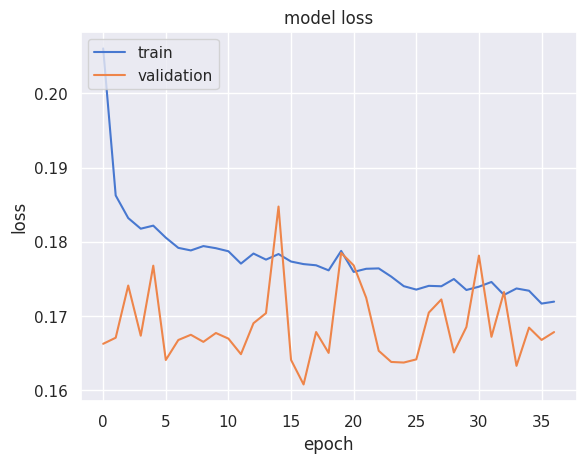

In [105]:
plot_model("loss", history)

In [106]:
predictions = model.predict(x_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Create a table with the metrics
metrics_table = pd.DataFrame({'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R-squared (R2)'],
                             'Value': [mse, rmse, mae, r2]})

print(metrics_table)

6/6 [==============================] - 0s 1ms/step
                           Metric     Value
0        Mean Squared Error (MSE)  0.027644
1  Root Mean Squared Error (RMSE)  0.166266
2       Mean Absolute Error (MAE)  0.104834
3                  R-squared (R2)  0.053410


Interestingly, the model doesn't seem to perform much better. Now, it would be interesting to test different models, such as XGB, or Random Forest. But beyond that, adding more data would also be a good plan.

##### Feature importance
To have a better idea on the features influencing our results, we performed Feature Importance analysis with a Random Forest decision tree

Feature: Temperature, Score: 0.10824
Feature: Tide, Score: 0.10985
Feature: Weather, Score: 0.02428
Feature: Zone, Score: 0.09417
Feature: Supra/Middle, Score: 0.20788
Feature: time_to_15h, Score: 0.21955
Feature: days_to_mid_summer_day, Score: 0.23603


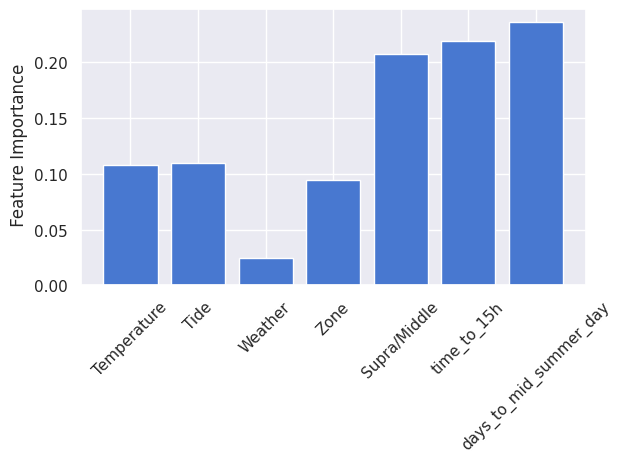

In [107]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)

# Define feature names
feature_names = ['Temperature', 'Tide', 'Weather', 'Zone', 'Supra/Middle', 'time_to_15h', 'days_to_mid_summer_day'] #, 'group_1_vals', 'group_2_vals', 'group_3_vals', 'group_4_vals', 'group_5_vals']

# define the model
model = RandomForestRegressor()

# fit the model
model.fit(x_train, y_train)

# get importance
importance = model.feature_importances_

# Summarize feature importance
for i, v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (feature_names[i], v))

# Plot feature importance
plt.bar(feature_names, importance)
plt.ylabel(" Feature Importance")
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

We can see that our engineered features time_to_15h and days_to_mid_summer_day had the largest impact in model performance. Supra/Middle tidal zones also have a significant impact in species' count.

### 3rd try: Predicting in 5 groups of species

Finally we will try to predict the values for 5 groups of species instead of just dividing between sessil and mobile species.

In [108]:
# Groups

species_in_group_1 = ['Chthamalus sp.', 'Balanus perforatus', 'Patella sp.', 'Siphonaria algesirae', 'Gibbula sp.', 'Monodonta lineata', 'Littorina neritoides', 'Mytillus sp.', 'Nassariidae (búzio)', 'Chiton sp.', 'Pollicipes pollicipes', 'Actinia equina ', 'Anemonia sulcata ', 'Ophiothrix sp.', 'Paracentrotus lividus', 'Hymeniacidon sanguinea', 'Aglaophenia pluma (hidrozoário branco ramificado)', 'Alga branca ramificada', 'Sabellaria alveolata  (tubos)', 'Cerianthidae', 'Anémona N.I.', 'Actinia fragacea', 'Gymnangium montagui', 'Anémona branca com estrias (fam. Cerianthidae)', 'Actinothoe sphyrodeta (anémona branca e laranja)', 'Oncidiella celtica (lesma)', 'Calliostoma sp. (burrié bicudo)', 'Polysyncraton sp. (ascídias vermelhas)', 'Didemnum sp. (ascídeas brancas)', 'Burrié negro N.I.', 'Búzio/burrié n.i.', 'Watersipora subtorquata (Ascídea)']
species_in_group_2 = ['Verrucaria maura ', 'Lichina pygmaea (líquene folhoso)']
species_in_group_3 = ['Coralina elongata', 'Lithophillum incrustans', 'Litophylum lichenoides', 'Litophylum tortuosum', 'Mesophylum lichenoides', 'Gelidium sp. (tipo raquete)', 'Asparagopsis armata (tufosa)', 'Asparagopsis armata (adulta)', 'Porphyra sp.', 'Ceramium (forma taças)', 'Mastocarpus sp. (alga preta só mediolitoral)', 'Gigartina sp. (língua do diabo)', 'Plocamium sp.', 'Caulacanthus sp.', 'Condracanthus', 'Alga vermelha filamentosa', 'Alga vermelha vesicular', 'Alga vermelha laminada', 'Alga vermelha carnuda', 'Hildenbrandia sp. (incrustante vermelha)', 'Chondria coerulescens (alga verde/azul filamentosa)', 'Alga vermelha "encaracolada" (que parece ceramium pequeno) ', 'Alga vermelha semelhante a Ulva rigida', 'Porphira', 'Osmundea pinnatifida', 'Alga vermelha ramificada (Polysiphonia?)', 'Ahnfeltiopsis devoniensis']
species_in_group_4 = ['Stypocaulon scoparium (alga verde tufosa que parece pinheiro)', 'Ulva rigida', 'Cladophora sp. (limo)', 'Limo N.I.', 'Ulva intestinalis', 'Ulva sp. ', 'Codium sp. (alga verde carnuda)', 'Alga verde carnuda ramificada', 'Nemoderma sp.(alga tipo musgo)', 'alga verde tufosa', 'alga verde (tipo couve flor)', 'Alga verde incrustante', 'Alga verde n.i.', 'Alga verde filamentosa', 'Alga amarela tipo codium viscoso', 'Cladostephus spongiosus (codium que parece que tem areia)', 'Codium adhaerens (tipo nenúfar)']
species_in_group_5 = ['Colpomenia sinuosa (alga bolhas)', 'Fucus vesiculosus ', 'Dictyota dichotoma (alga azul laminada)', 'Dictyota castanha', 'Alga castanha sp.', 'Alga castanha laminada', 'Alga castanha filamentosa', 'Alga castanha incrustante', 'Alga castanha carnuda', 'Alga castanha tufosa', 'Alga verde/azul - lavanda', 'Sphacelaria rigidula (pompons castanhos)', 'Cystoseira sp.', 'Laminaria sp.']

In [109]:
group_1_vals = np.zeros(len(df))
group_2_vals = np.zeros(len(df))
group_3_vals = np.zeros(len(df))
group_4_vals = np.zeros(len(df))
group_5_vals = np.zeros(len(df))

for col in df.columns:

    if col in species_in_group_1:
        group_1_vals += df[col]

    if col in species_in_group_2:
        group_2_vals += df[col]

    if col in species_in_group_3:
        group_3_vals += df[col]

    if col in species_in_group_4:
        group_4_vals += df[col]

    if col in species_in_group_5:
        group_5_vals += df[col]

# Merging the output data

output_array_by_group = np.stack([group_1_vals, group_2_vals, group_3_vals, group_4_vals, group_5_vals]).T

##### Re-normalize and split the data

In [110]:
scaler = MinMaxScaler(feature_range=(0,1))
# fit scaler on data
scaler.fit(output_array_by_group)
# apply transform
normalized_output = scaler.transform(output_array_by_group)

x_train, y_train = normalized_input[:int(0.8*normalized_input.shape[0])], normalized_output[:int(0.8*normalized_input.shape[0])]
x_val, y_val = normalized_input[int(0.8*normalized_input.shape[0]):int(0.9*normalized_input.shape[0])], normalized_output[int(0.8*normalized_input.shape[0]):int(0.9*normalized_input.shape[0])]
x_test, y_test = normalized_input[int(0.9*normalized_input.shape[0]):], normalized_output[int(0.9*normalized_input.shape[0]):]

In [111]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

model = tf.keras.models.Sequential(
    layers=[
        tf.keras.layers.Dense(256, input_dim=x_train.shape[1], activation="relu", name="input"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation="relu", name="layer1"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation="relu", name="layer2"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation="relu", name="layer3"),
        tf.keras.layers.Dense(y_train.shape[1], name="output")
    ])

model.summary()

optimizer = tf.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss=root_mean_squared_error) 

history = model.fit(x_train, y_train,
                   validation_data=(x_val, y_val),
                   batch_size=32,
                   epochs=200,  callbacks=[callback], shuffle=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               2048      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 layer1 (Dense)              (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 layer2 (Dense)              (None, 128)               32896     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 layer3 (Dense)              (None, 128)              

Epoch 1/200
48/48 [==============================] - 1s 3ms/step - loss: 0.1695 - val_loss: 0.1705
Epoch 2/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1621 - val_loss: 0.1686
Epoch 3/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1608 - val_loss: 0.1711
Epoch 4/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1605 - val_loss: 0.1671
Epoch 5/200
48/48 [==============================] - 0s 3ms/step - loss: 0.1597 - val_loss: 0.1660
Epoch 6/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1591 - val_loss: 0.1676
Epoch 7/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1577 - val_loss: 0.1674
Epoch 8/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1589 - val_loss: 0.1672
Epoch 9/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1580 - val_loss: 0.1654
Epoch 10/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1577 - val_loss: 0.1697
Epoch 11/

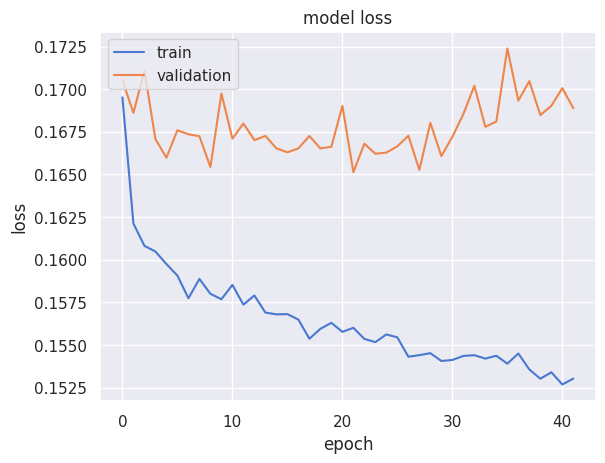

In [112]:
plot_model("loss", history)

In [113]:
predictions = model.predict(x_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Create a table with the metrics
metrics_table = pd.DataFrame({'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R-squared (R2)'],
                             'Value': [mse, rmse, mae, r2]})

print(metrics_table)

6/6 [==============================] - 0s 860us/step
                           Metric     Value
0        Mean Squared Error (MSE)  0.031087
1  Root Mean Squared Error (RMSE)  0.176316
2       Mean Absolute Error (MAE)  0.096877
3                  R-squared (R2) -1.062732


### 4th try: Giving the model species information as input

To give the model more information, we'll add the values for the groups of species from the lastest measurement

In [114]:
input1 = np.stack([temp, tide, weather, zone, supra_middle, time_to_15h, days_to_mid_summer_day]).T[1:] 
input2= np.stack([group_1_vals, group_2_vals, group_3_vals, group_4_vals, group_5_vals]).T[:-1] 

input_array_with_species_data =np.concatenate([input1, input2], axis=1)
output_array_by_group = np.stack([group_1_vals, group_2_vals, group_3_vals, group_4_vals, group_5_vals]).T[1:]

In [115]:
input_array_with_species_data .shape

(1910, 12)

In [116]:
scaler = MinMaxScaler(feature_range=(0,1))
# fit scaler on data
scaler.fit(input_array_with_species_data)
# apply transform
normalized_input = scaler.transform(input_array_with_species_data)

scaler = MinMaxScaler(feature_range=(0,1))
# fit scaler on data
scaler.fit(output_array_by_group)
# apply transform
normalized_output = scaler.transform(output_array_by_group)

x_train, y_train = normalized_input[:int(0.8*normalized_input.shape[0])], normalized_output[:int(0.8*normalized_input.shape[0])]
x_val, y_val = normalized_input[int(0.8*normalized_input.shape[0]):int(0.9*normalized_input.shape[0])], normalized_output[int(0.8*normalized_input.shape[0]):int(0.9*normalized_input.shape[0])]
x_test, y_test = normalized_input[int(0.9*normalized_input.shape[0]):], normalized_output[int(0.9*normalized_input.shape[0]):]

In [117]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

model = tf.keras.models.Sequential(
    layers=[
        tf.keras.layers.Dense(256, input_dim=x_train.shape[1], activation="relu", name="input"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation="relu", name="layer1"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation="relu", name="layer2"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation="relu", name="layer3"),
        tf.keras.layers.Dense(y_train.shape[1], name="output")
    ])

model.summary()

optimizer = tf.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss=root_mean_squared_error) 

history = model.fit(x_train, y_train,
                   validation_data=(x_val, y_val),
                   batch_size=32,
                   epochs=200,  callbacks=[callback], shuffle=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               3328      
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 layer1 (Dense)              (None, 256)               65792     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 layer2 (Dense)              (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 layer3 (Dense)              (None, 128)              

Epoch 1/200
48/48 [==============================] - 1s 3ms/step - loss: 0.1670 - val_loss: 0.1661
Epoch 2/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1581 - val_loss: 0.1655
Epoch 3/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1569 - val_loss: 0.1663
Epoch 4/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1562 - val_loss: 0.1660
Epoch 5/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1546 - val_loss: 0.1659
Epoch 6/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1536 - val_loss: 0.1618
Epoch 7/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1534 - val_loss: 0.1621
Epoch 8/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1527 - val_loss: 0.1613
Epoch 9/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1530 - val_loss: 0.1611
Epoch 10/200
48/48 [==============================] - 0s 2ms/step - loss: 0.1528 - val_loss: 0.1594
Epoch 11/

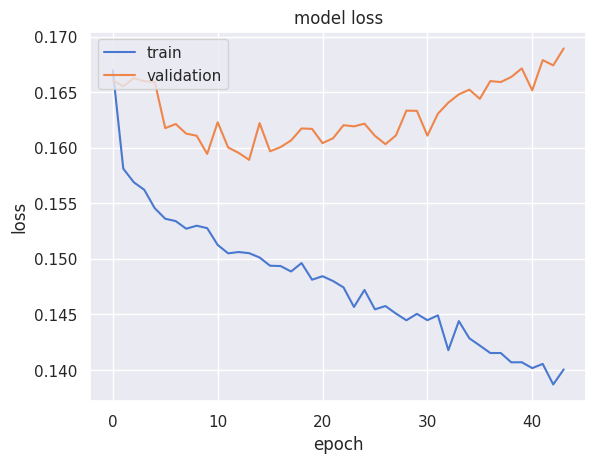

In [118]:
plot_model("loss", history)

In [119]:
predictions = model.predict(x_test)

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Create a table with the metrics
metrics_table = pd.DataFrame({'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R-squared (R2)'],
                             'Value': [mse, rmse, mae, r2]})

print(metrics_table)

6/6 [==============================] - 0s 870us/step
                           Metric     Value
0        Mean Squared Error (MSE)  0.029891
1  Root Mean Squared Error (RMSE)  0.172890
2       Mean Absolute Error (MAE)  0.095495
3                  R-squared (R2) -1.036941


Both the model and the input/output selection must be rethinked, however several approaches were investigated here as a proof of concept.

#### Feature importance
To have a better idea on the features influencing our results, we performed Feature Importance analysis with a Random Forest decision tree

Feature: Temperature, Score: 0.05906
Feature: Tide, Score: 0.06893
Feature: Weather, Score: 0.01433
Feature: Zone, Score: 0.05429
Feature: Supra/Middle, Score: 0.14540
Feature: time_to_15h, Score: 0.08829
Feature: days_to_mid_summer, Score: 0.12125
Feature: group_1, Score: 0.12946
Feature: group_2, Score: 0.01935
Feature: group_3, Score: 0.14576
Feature: group_4, Score: 0.11260
Feature: group_5, Score: 0.04127


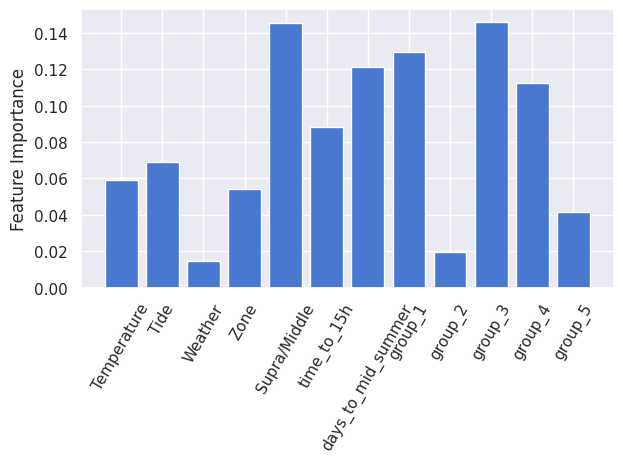

In [120]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Generate regression dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)

# Define feature names
feature_names = ['Temperature', 'Tide', 'Weather', 'Zone', 'Supra/Middle', 'time_to_15h', 'days_to_mid_summer', 'group_1', 'group_2', 'group_3', 'group_4', 'group_5']

# Create a random forest regressor
model = RandomForestRegressor()

# Fit the model
model.fit(x_train, y_train)

# Get feature importances
importance = model.feature_importances_

# Print feature importance scores
for name, score in zip(feature_names, importance):
    print(f'Feature: {name}, Score: {score:.5f}')

# Plot feature importance
plt.bar(feature_names, importance)
plt.ylabel('Feature Importance')
plt.xticks(rotation=60)  # Rotate x-axis labels by 45 degrees
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

We can see again that our engineered features time_to_15h and days_to_mid_summer_day had large impact in model performance, together with Supra/Middle tidal zones. Groups 1, 3, and 4 also had a significant impact.

## 🖼️ Visualisations

### Removing rows with missing Date and Hour

Checking if removing rows without a Date and Hour meant losing a lot of information. In conclusion, when Date and Hour were missing, most of the other columns were missing too, the large majority of the times.

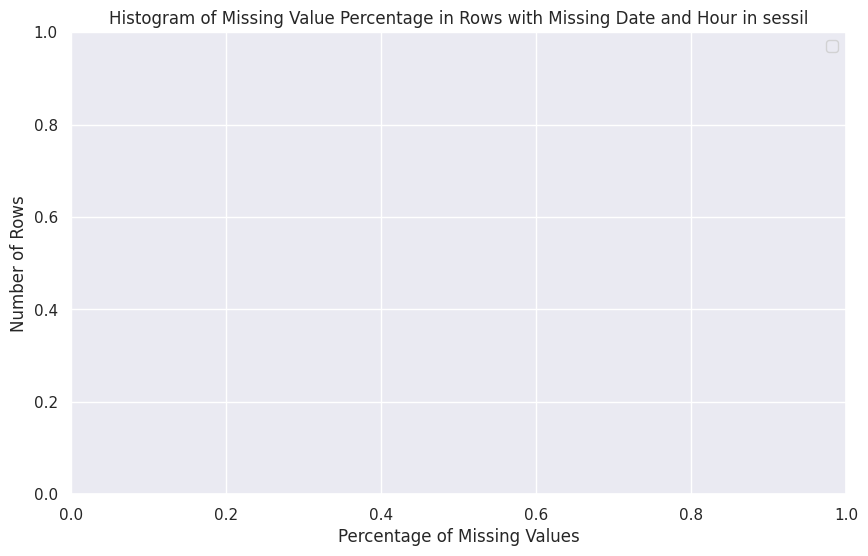

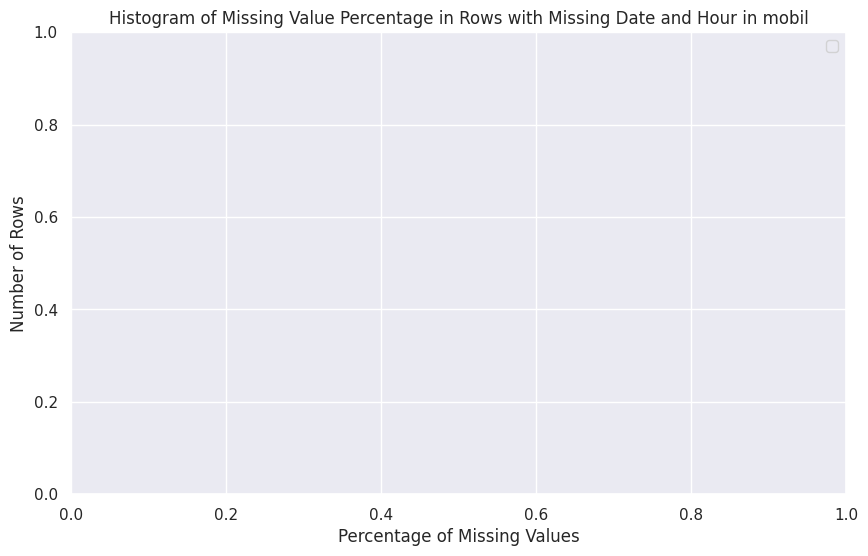

In [121]:
# Filter rows where both 'Date' and 'Hour' are missing
sessil_missing_date_hour = sessil_df[sessil_df[['Date', 'Hour']].isnull().all(axis=1)]
mobile_missing_date_hour = mobil_df[mobil_df[['Date', 'Hour']].isnull().all(axis=1)]

# Calculate the percentage of missing values in each row
sessil_missing_perc = sessil_missing_date_hour.isnull().mean(axis=1)
mobile_missing_perc = mobile_missing_date_hour.isnull().mean(axis=1)

# Create a new figure for sessil dataframe
plt.figure(figsize=(10,6))
sns.histplot(sessil_missing_perc, bins=10, label='sessil_meta_info_df', kde=False, color='blue')
plt.title('Histogram of Missing Value Percentage in Rows with Missing Date and Hour in sessil')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Rows')
plt.legend()
# plt.show()

# Create a new figure for mobile dataframe
plt.figure(figsize=(10,6))
sns.histplot(mobile_missing_perc, bins=10, label='mobile_meta_info_df', kde=False, color='red')
plt.title('Histogram of Missing Value Percentage in Rows with Missing Date and Hour in mobil')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Rows')
plt.legend()
# plt.show()

<img src="images/sessil_barplot.png" alt="Sessil barplot" style="width:35%">

<img src="images/mobil_barplot.png" alt="Mobil barplot" style="width:35%">

### After dropping unknown and other substrate

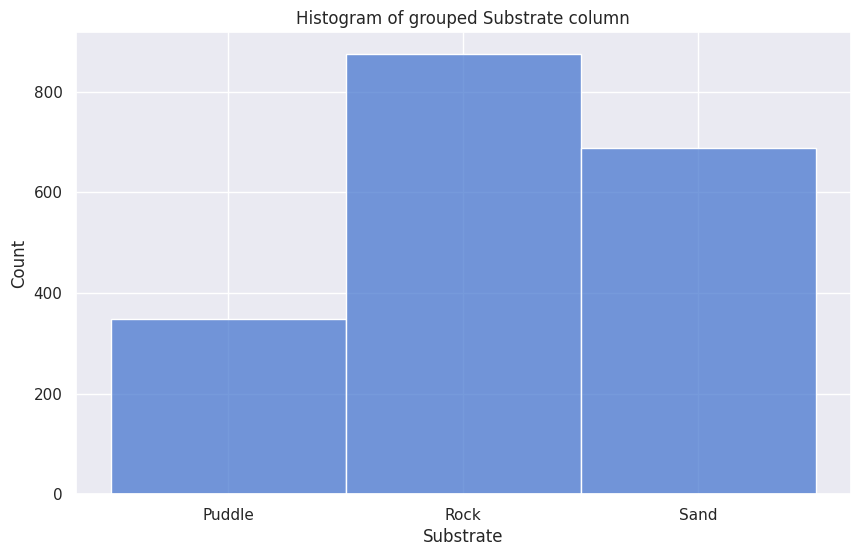

In [122]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Substrate')
plt.title('Histogram of grouped Substrate column')
plt.show()

### After removing Zone F

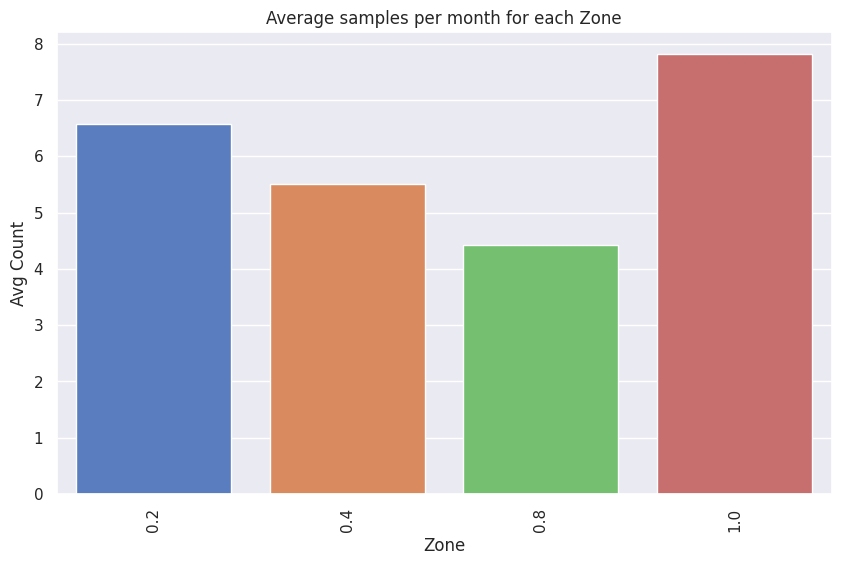

In [123]:
# Group by both 'Zone' and 'Month' and calculate average
monthly_samples = df.groupby(['Zone', 'Month']).size()\
    .groupby(['Zone']).mean().reset_index(name='Avg Count')

plt.figure(figsize=(10,6))
sns.barplot(data=monthly_samples, x='Zone', y='Avg Count')
plt.title('Average samples per month for each Zone')
plt.xticks(rotation=90)
plt.show()

### Analysis of Mobil species values

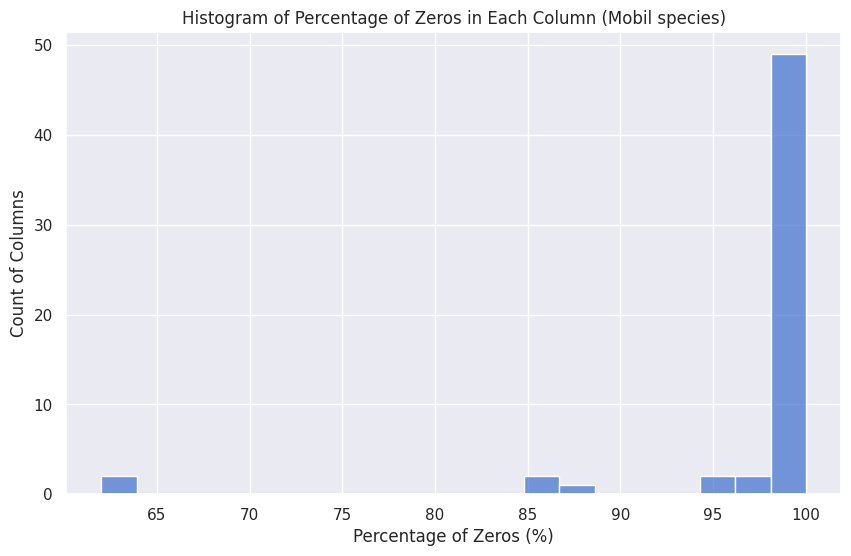

In [124]:
# Calculate the percentage of zeros for each column and save it to a list
percentage_zeros = [(df[col] == 0).mean() * 100 for col in mobil_species_columns]

# Plot a histogram of the percentage of zeros
plt.figure(figsize=(10,6))
sns.histplot(percentage_zeros, bins=20, kde=False)
plt.title('Histogram of Percentage of Zeros in Each Column (Mobil species)')
plt.xlabel('Percentage of Zeros (%)')
plt.ylabel('Count of Columns')
plt.show()

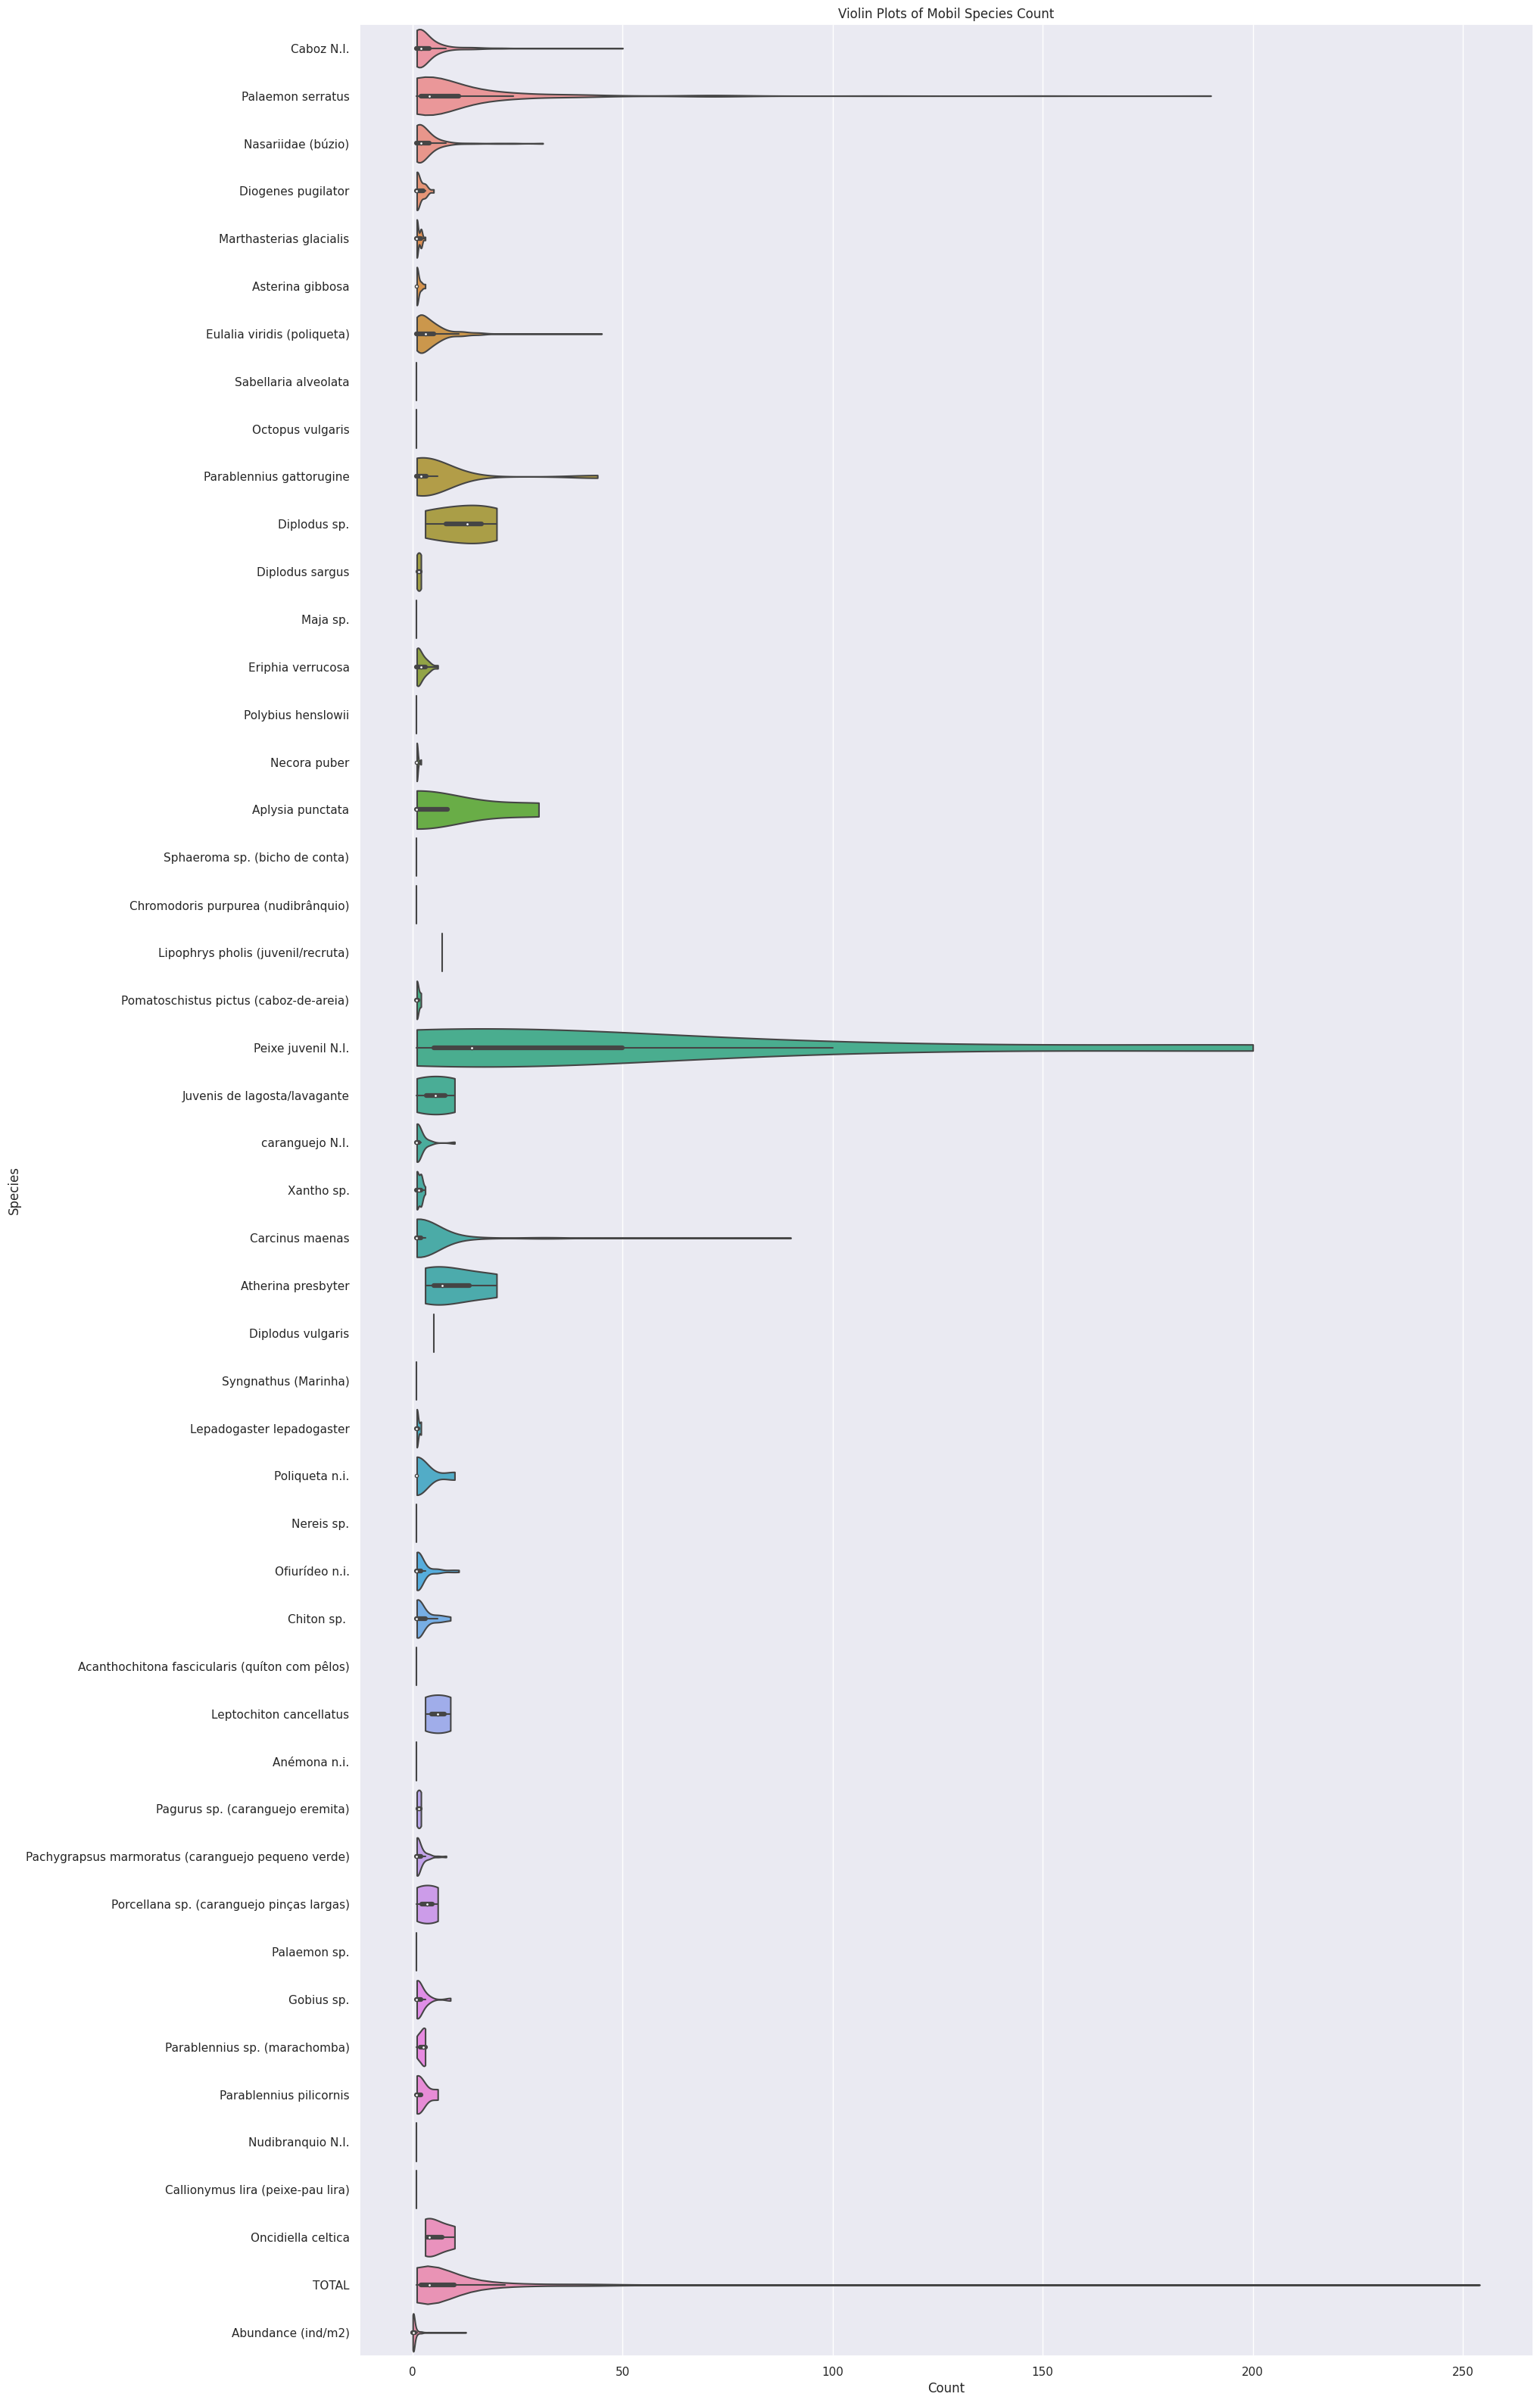

In [125]:
# Reshape to long format. Assuming df is your dataframe.
df_melted = df[mobil_species_columns].melt(var_name='Species', value_name='Count')

# Convert the 'Coverage' column to a numeric data type
df_melted['Count'] = pd.to_numeric(df_melted['Count'], errors='coerce')

# Remove zero values
df_melted = df_melted[df_melted['Count'] != 0]

# Increase the size of the plot
plt.figure(figsize=(20, 40))

# Create violin plot
sns.violinplot(data=df_melted, y='Species', x='Count', scale='width', cut=0)

# Show the plot
plt.title('Violin Plots of Mobil Species Count')
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57]),
 [Text(0, 0, 'Caboz N.I.'),
  Text(0, 1, 'Diplodus vulgaris'),
  Text(0, 2, 'Syngnathus (Marinha)'),
  Text(0, 3, 'Lepadogaster lepadogaster'),
  Text(0, 4, 'Poliqueta n.i.'),
  Text(0, 5, 'Nereis sp.'),
  Text(0, 6, 'Ofiurídeo n.i.'),
  Text(0, 7, 'Chiton sp. '),
  Text(0, 8, 'Acanthochitona fascicularis (quíton com pêlos)'),
  Text(0, 9, 'Leptochiton cancellatus'),
  Text(0, 10, 'Anémona n.i.'),
  Text(0, 11, 'Pagurus sp. (caranguejo eremita)'),
  Text(0, 12, 'Pachygrapsus marmoratus (caranguejo pequeno verde)'),
  Text(0, 13, 'Porcellana sp. (caranguejo pinças largas)'),
  Text(0, 14, 'Palaemon sp.'),
  Text(0, 15, 'Gobius sp.'),
  Text(0, 16, 'Parablennius sp. (marachomba)'),
  Text(0, 17, 'Parablennius pilicornis'),
  T

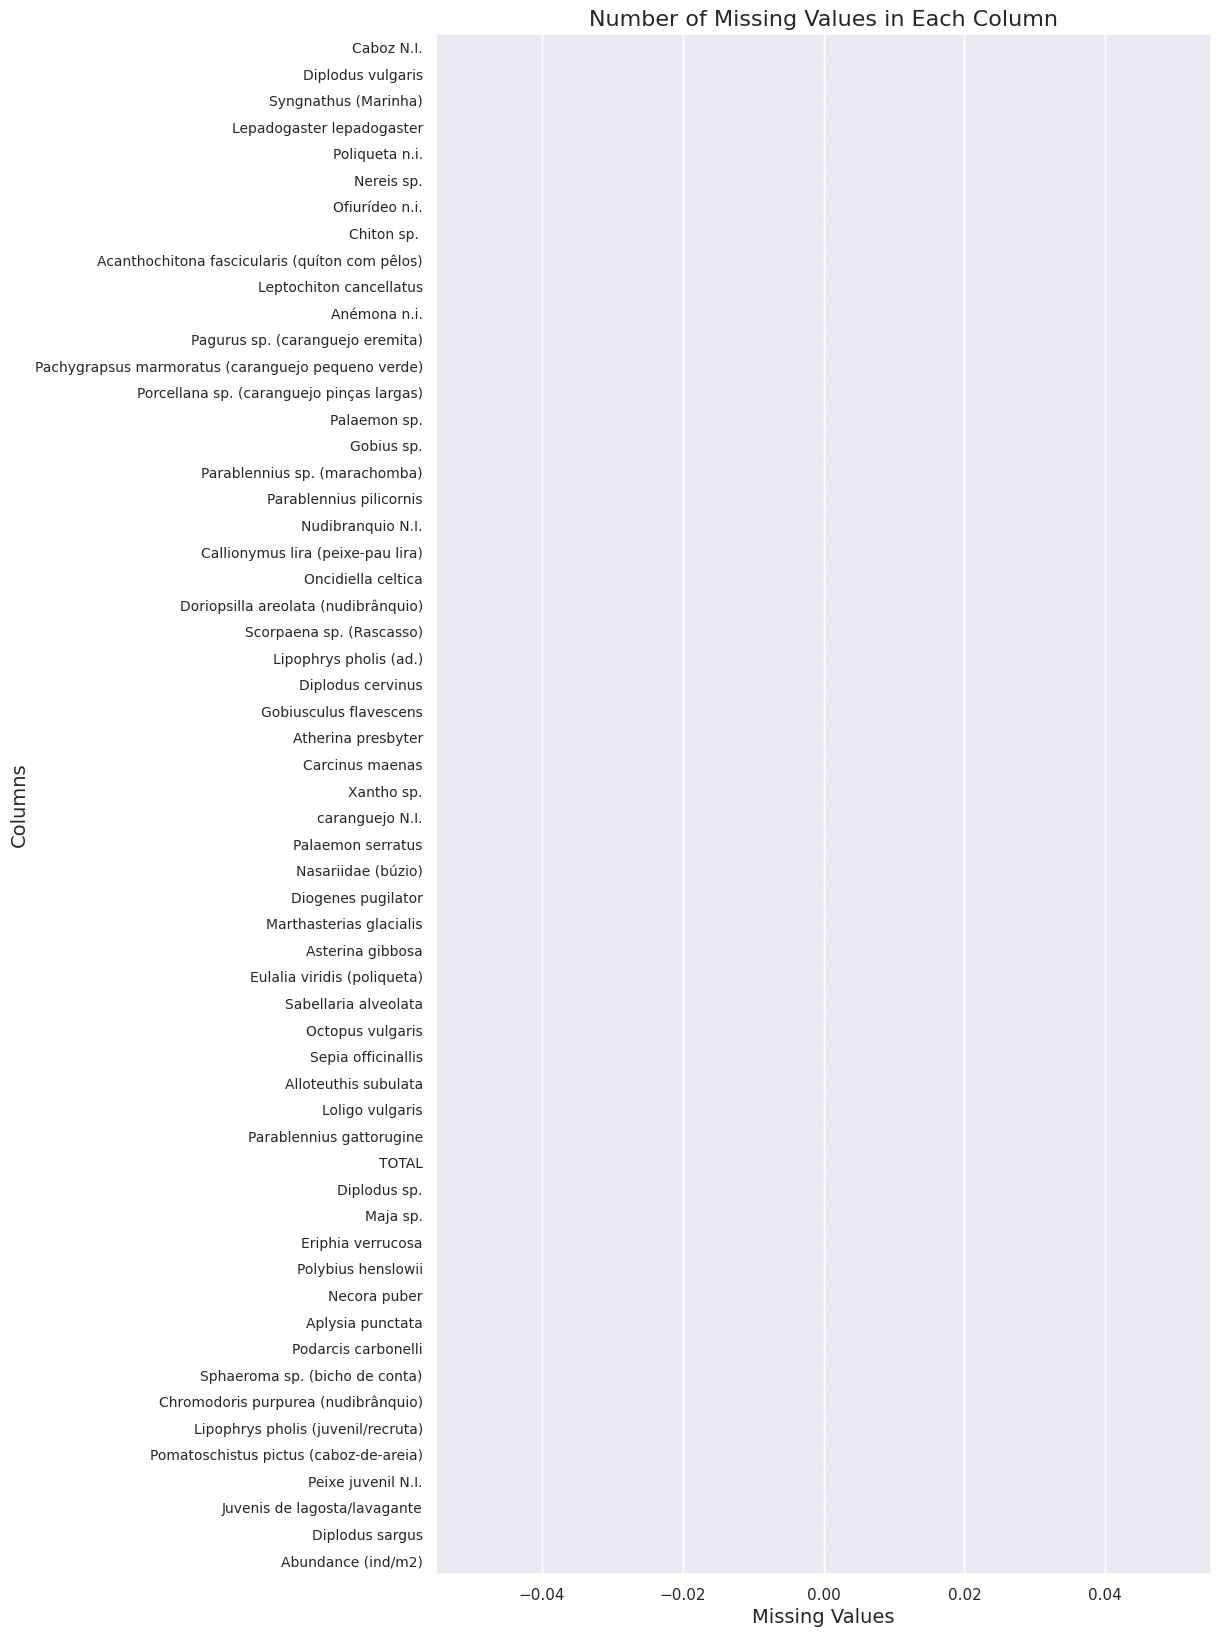

In [126]:
# This has to be run before removing the missing values, otherwise empty
# Re-Calculate the number of missing values in each column
missing_values = df[mobil_species_columns].isnull().sum()

# Convert Series to DataFrame for seaborn
missing_values_df = missing_values.reset_index()
missing_values_df.columns = ['Column', 'Missing Values']

# Sort DataFrame by number of missing values
missing_values_df = missing_values_df.sort_values(by='Missing Values', ascending=True)

# Create seaborn barplot
plt.figure(figsize=(10, 20))  # adjust size as needed
sns.barplot(x='Missing Values', y='Column', data=missing_values_df, palette='viridis')

plt.title('Number of Missing Values in Each Column', fontsize=16)
plt.xlabel('Missing Values', fontsize=14)
plt.ylabel('Columns', fontsize=14)
plt.yticks(fontsize=10)  # adjust fontsize as needed

# splt.show()

<img src="images/missing_mobil.png" alt="Missing mobils" style="width:85%">

In [127]:
# This has to be run before removing the missing values, otherwise empty
print("mobil_df")
# plot_missing_overlap(df, mobil_species_columns, annot=False)

mobil_df


<img src="images/missing_mobil_pairs.png" alt="Moibl missing barplot" style="width:85%">

### Pairplot of top correlated columns

/tmp/ipykernel_7306/570583139.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


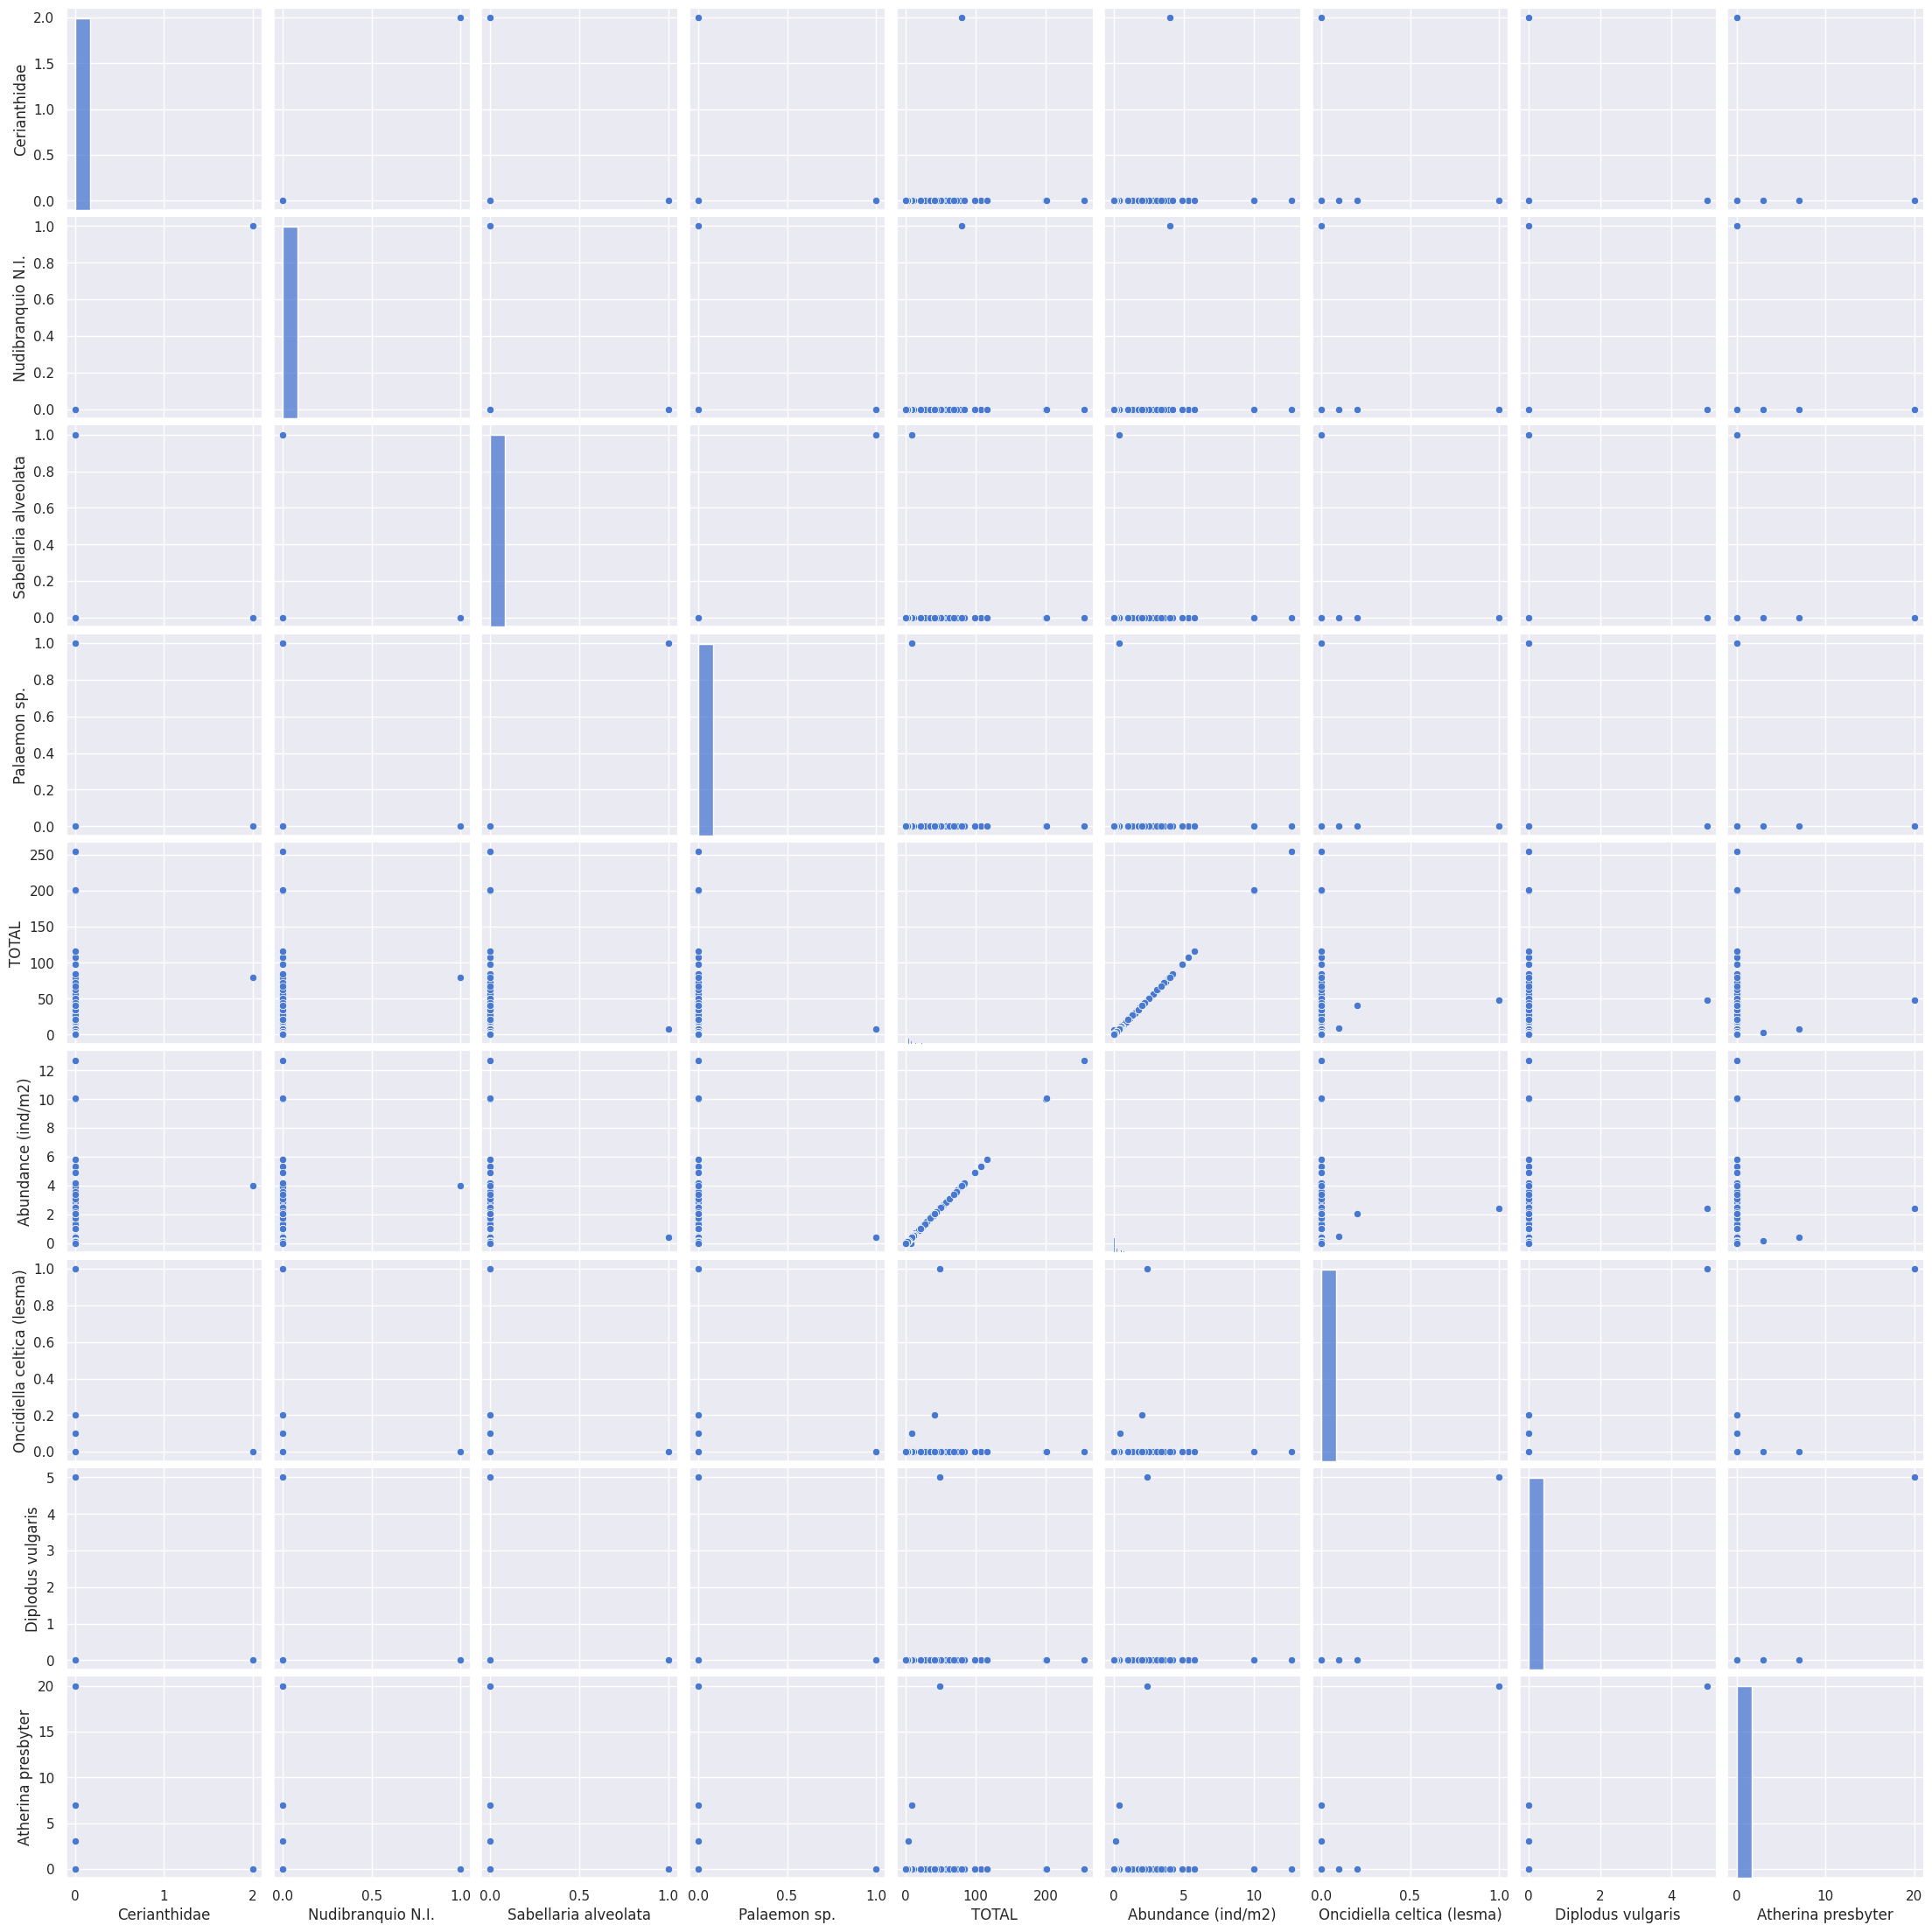

In [128]:
# Calculate the correlation
corr = df.corr()

# Create a mask to ignore self-correlation
mask = np.triu(np.ones_like(corr, dtype=bool))

# Flatten the correlation matrix to a one-dimensional series
corr_values = corr.mask(mask).abs().unstack()

# Sort the series in descending order
sorted_corr_values = corr_values.sort_values(ascending=False)

# Get the top 5 pairs with the highest correlation
top_5_corr_pairs = sorted_corr_values.index[:5]

# Get unique column names from the top pairs
top_corr_columns = pd.Index([col for pair in top_5_corr_pairs for col in pair]).unique()

# Plot a pairplot of the top correlated columns
sns.pairplot(df[list(top_corr_columns)])
plt.show()

## 👓 References
Ferreira et al. 2017 (https://doi.org/10.1016/j.ecolind.2017.06.028)

## ⏭️ Appendix


### Get groups of Sessil

In [129]:
from openpyxl import load_workbook
from collections import defaultdict

# Load the workbook
wb = load_workbook(filename=data_path)

# Select the sheet
ws = wb['Sessil (% Coverage)']  # Change to your sheet name

# Create a dictionary to store cell values by color
color_groups = defaultdict(list)

# For each cell in the first row
for cell in ws[1]:
    color = cell.fill.start_color.index
    color_groups[color].append(cell.value)

# Now color_groups contains groups of cell values, grouped by their color
for color, values in color_groups.items():
    print(f"Color: {color}, Values: {values}")

Color: FF548DD4, Values: ['Date', 'Hour', 'Tide', 'Weather Condition', 'Water temperature (ºC)', 'Sampler', 'Zone', 'Supratidal/Middle Intertidal', 'Substrate']
Color: FF92CDDC, Values: ['Chthamalus sp.', 'Balanus perforatus', 'Patella sp.', 'Siphonaria algesirae', 'Gibbula sp.', 'Monodonta lineata', 'Littorina neritoides', 'Mytillus sp.', 'Nassariidae (búzio)', 'Chiton sp.', 'Pollicipes pollicipes', 'Actinia equina ', 'Anemonia sulcata ', 'Ophiothrix sp.', 'Paracentrotus lividus', 'Hymeniacidon sanguinea', 'Aglaophenia pluma (hidrozoário branco ramificado)', 'Alga branca ramificada', 'Sabellaria alveolata  (tubos)', 'Cerianthidae', 'Anémona N.I.', 'Actinia fragacea', 'Gymnangium montagui', 'Anémona branca com estrias (fam. Cerianthidae)', 'Actinothoe sphyrodeta (anémona branca e laranja)', 'Oncidiella celtica (lesma)', 'Calliostoma sp. (burrié bicudo)', 'Polysyncraton sp. (ascídias vermelhas)', 'Didemnum sp. (ascídeas brancas)', 'Burrié negro N.I.', 'Búzio/burrié n.i.', 'Watersipora s

### Model 2 Results and Feature Importance- Predicting species' count

                           Metric     Value
        Mean Squared Error (MSE)  0.026536
        Root Mean Squared Error (RMSE)  0.162899
        Mean Absolute Error (MAE)  0.101349
        R-squared (R2)  0.070531

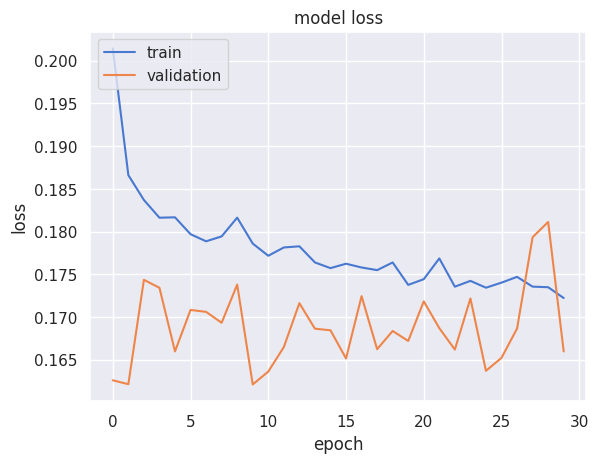

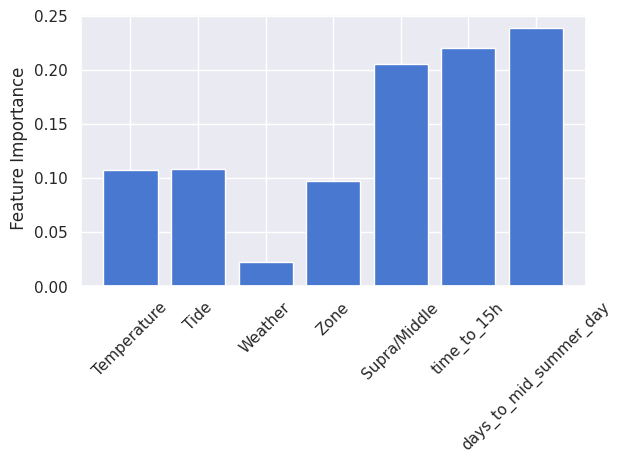

### Model 4 Results and Feature Importance - Predicting taxon group's count

                           Metric     Value
        Mean Squared Error (MSE)  0.030928
        Root Mean Squared Error (RMSE)  0.175865
        Mean Absolute Error (MAE)  0.095063
        R-squared (R2) -0.844035

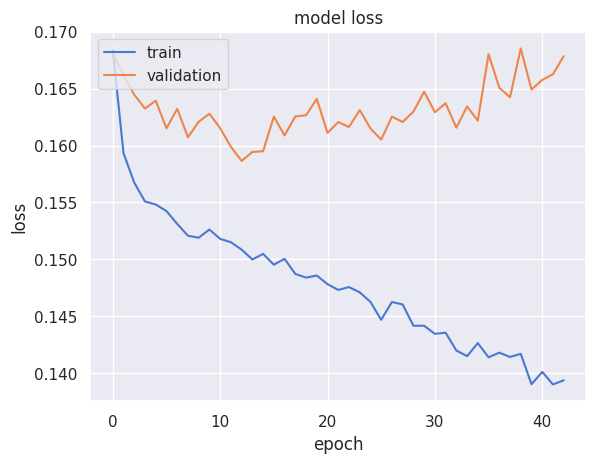

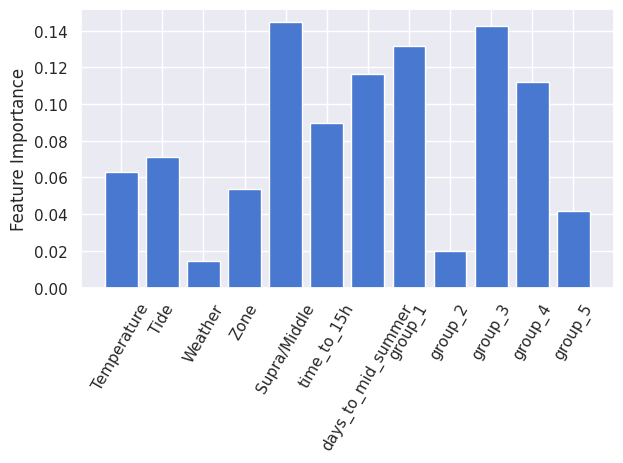